# Supervised Predictive Machine Maintenance

**Goals**
- In the industrial and manufacturing sectors, machine maintenance is crucial to ensure smooth production and prevent downtime that can be costly for the company.
- Maintenance refers to the systematic practices of preserving and repairing equipment to sustain peak performance.
- Implementing a predictive mechanism is necessary to identify machines at risk of failure.

**Objective**
- Perform predictive modeling for machine failure (whether the machine needs a maintenance or not)
- Focus on *Recall* or *F1-Score*, as a false negative (failing to detect a failure) is far more costly than a false positive (incorrectly detecting one).

**Outline**
- Exploratory Data Analysis
  - Statistical characteristic of all features.
  - Focusing on the factors that lead to machine failure.
  - Impact of features on failure types for subsequent modeling.
- Data Preprocessing
  - Data cleaning (data validation, missing value, duplicate value, *outlier handling*)
  - Feature encoding
  - Feature engineering
  - Feature scaling
- Supervised Machine Learning Modeling
- Model Evaluation
- Conclusion

---

In [1]:
# import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# <font color = 'blue'> Dataset Overview
---

**Overview** <br>

The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry. Since real predictive maintenance datasets are generally difficult to obtain and in particular difficult to publish, we present and provide a synthetic dataset that reflects real predictive maintenance encountered in industry to the best of our knowledge.

**Import Dataset Here**

In [2]:
!pip install ucimlrepo

In [3]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
ai4i_2020_predictive_maintenance_dataset = fetch_ucirepo(id=601)

# data (as pandas dataframes)
X = ai4i_2020_predictive_maintenance_dataset.data.features
y = ai4i_2020_predictive_maintenance_dataset.data.targets

# metadata
print(ai4i_2020_predictive_maintenance_dataset.metadata)

print('')

# variable information
print(ai4i_2020_predictive_maintenance_dataset.variables)

{'uci_id': 601, 'name': 'AI4I 2020 Predictive Maintenance Dataset', 'repository_url': 'https://archive.ics.uci.edu/dataset/601/ai4i+2020+predictive+maintenance+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/601/data.csv', 'abstract': 'The AI4I 2020 Predictive Maintenance Dataset is a synthetic dataset that reflects real predictive maintenance data encountered in industry.', 'area': 'Computer Science', 'tasks': ['Classification', 'Regression', 'Causal-Discovery'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 10000, 'num_features': 6, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF'], 'index_col': ['UID', 'Product ID'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5HS5C', 'creators': [], 'intro_paper': {'ID': 386, 'type': 'NATIVE', 'title': 'Explainable Artificial Intelligen

**Additional Variable Information** <br>
The dataset consists of 10000 data points stored as rows with 14 features in columns which contains:<br>

**ID related**
- `UID` : unique identifier ranging from 1 to 10000
- `Product ID`

**Features**
- `Type` : consisting of a letter L, M, or H for low (50% of all products), medium (30%) and high (20%) as product quality variants and a variant-specific serial number
- `Air temperature` [K]: generated using a random walk process later normalized to a standard deviation of 2 K around 300 K
- `Process temperature` [K]: generated using a random walk process normalized to a standard deviation of 1 K, added to the air temperature plus 10 K.
- `Rotational speed` [rpm]: calculated from a power of 2860 W, overlaid with a normally distributed noise
- `Torque` [Nm]: torque values are normally distributed around 40 Nm with a Ïƒ = 10 Nm and no negative values.
- `Tool wear` [min]: The quality variants H/M/L add 5/3/2 minutes of tool wear to the used tool in the process.

**Target**
- `Machine failure` label that indicates, whether the machine has failed in this particular datapoint for any of the following failure modes are true.

The machine failure consists of five independent failure modes:
- tool wear failure (`TWF`): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- heat dissipation failure (`HDF`): heat dissipation causes a process failure, if the difference between air- and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
- power failure (`PWF`): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- overstrain failure (`OSF`): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- random failures (`RNF`): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

If at least one of the above failure modes is true, the process fails and the `Machine failure` label is set to 1. It is therefore not transparent to the machine learning method, which of the failure modes has caused the process to fail.

In [4]:
# feature dataset
X.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
0,M,298.1,308.6,1551,42.8,0
1,L,298.2,308.7,1408,46.3,3
2,L,298.1,308.5,1498,49.4,5
3,L,298.2,308.6,1433,39.5,7
4,L,298.2,308.7,1408,40.0,9


In [5]:
# target
y.head()

,Machine failure,TWF,HDF,PWF,OSF,RNF
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [6]:
# create dataset that contain X and y
data = pd.concat([X, y], axis = 1)
data.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
0,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


# <font color = 'blue'> Exploratory Data Analysis
---

## Split the data into data train and data test

We will work only with data train for Exploratory Data Analysis

In [7]:
from sklearn.model_selection import train_test_split

# split data into data train and data test
data_train, data_test = train_test_split(data, test_size = 0.2, random_state = 42, stratify = data['Machine failure'])

In [8]:
print(data_train.shape)
print(data_test.shape)

(8000, 12)
(2000, 12)


## Univariate analysis for each features

### Feature distribution

In [9]:
# take a look to data_train
data_train.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
4058,M,302.0,310.9,1456,47.2,54,0,0,0,0,0,0
1221,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1
6895,M,301.0,311.6,1357,45.6,137,0,0,0,0,0,0
9863,L,298.9,309.8,1411,56.3,84,0,0,0,0,0,0
8711,L,297.1,308.5,1733,28.7,50,0,0,0,0,0,0


In [10]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4058 to 1424
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 8000 non-null   object 
 1   Air temperature      8000 non-null   float64
 2   Process temperature  8000 non-null   float64
 3   Rotational speed     8000 non-null   int64  
 4   Torque               8000 non-null   float64
 5   Tool wear            8000 non-null   int64  
 6   Machine failure      8000 non-null   int64  
 7   TWF                  8000 non-null   int64  
 8   HDF                  8000 non-null   int64  
 9   PWF                  8000 non-null   int64  
 10  OSF                  8000 non-null   int64  
 11  RNF                  8000 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 812.5+ KB


In [11]:
# duplicate checking
data_train.duplicated().sum()

np.int64(0)

In [12]:
# divide the column in data_train into features, failure_types, and target
failure_types = ['HDF', 'PWF', 'OSF', 'TWF', 'RNF']
target = 'Machine failure'
categorical = 'Type'
features = [col for col in data_train.columns if col not in [target, categorical] + failure_types]

**Distribution for each features**

In [13]:
# statistical characteristics
data_train[features].describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,300.005450,310.006062,1539.356875,40.003363,107.685000
std,1.996844,1.479432,180.982943,10.019546,63.612002
min,295.300000,305.700000,1168.000000,3.800000,0.000000
25%,298.300000,308.800000,1422.000000,33.200000,53.000000
50%,300.100000,310.100000,1503.000000,40.100000,107.000000
75%,301.500000,311.100000,1613.000000,46.800000,163.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


There are no anomalies; all values align with their respective feature definitions.

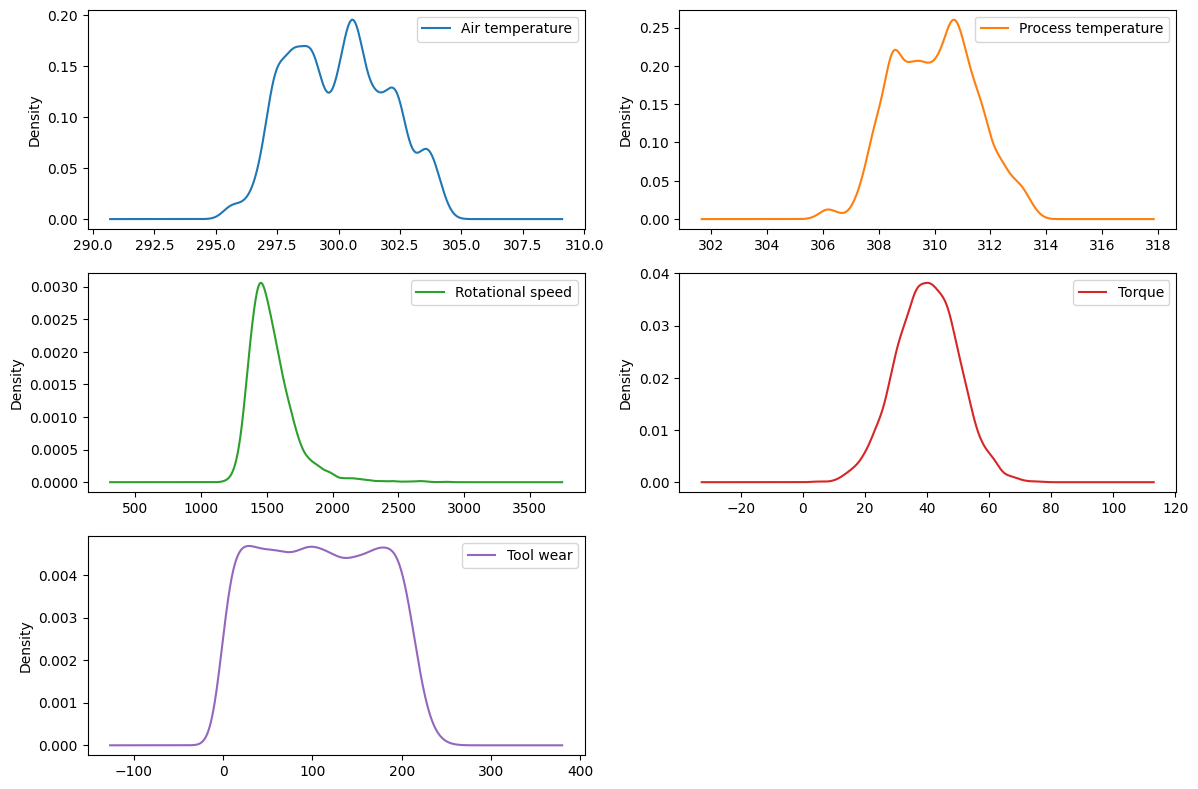

In [14]:
# distribution plot for numerical features
data_train[features].plot(kind = 'kde',
                          subplots = True,
                          layout = (3, 2),
                          figsize = (12, 8),
                          sharex = False)
plt.tight_layout()
plt.show()

In [15]:
# skewness
data_train[features].skew()

,0
Air temperature,0.121199
Process temperature,0.031926
Rotational speed,2.011305
Torque,-0.006539
Tool wear,0.035035


In [16]:
# distribution for machine type
data_train[categorical].value_counts(normalize = True)

,proportion
Type,
L,0.603750
M,0.297625
H,0.098625


In [17]:
# distribution for failure types
for i in failure_types:
    print(f'{i}: {data_train[i].value_counts()[1]/len(data_train):.2%}')

HDF: 1.07%
PWF: 1.03%
OSF: 1.03%
TWF: 0.45%
RNF: 0.19%


In [18]:
# distribution for machine failure
print(f'{target}: {data_train[target].value_counts()[1]/len(data_train):.2%}')

Machine failure: 3.39%


**Insight about feature distribution**
- `Rotational speed` exhibits positive skewness:
  - Most machines operate at ~1500 rpm, with some high-speed exceeding 2500 rpm
  - Applied median imputation for missing values
  - Extreme speeds often serve as an indicator of power failure
- `Torque` follows a near-normal distribution, indicating that the machine workload is relatively stable and standardized
- `Air temperature` and `Process temperature` exhibit multimodal distributions:
  - Multiple peaks in the distribution plots indicate data collection from diverse environments or varying operational heat levels
  - The high similarity between their distribution patterns suggests a strong correlation, where `Process temperature` is driven by `Air temperature`
- `Tool wear` follows a uniform-like distribution:
  - This indicates that the dataset records the entire machine life cycle evenly
  - This ensures the model is not biased toward any particular stage of tool wear or machine age

**Insight about target**
Machine failures account for only 3.39% of the dataset. This represents a significant class imbalance; therefore, we must be careful during modeling to ensure that appropriate evaluation metrics are used.

<font color = 'blue'> **Key Takeaways** <br>

Numerical features are imputed with the mean, except for the skewed `Rotational speed` (median), while categorical and boolean features are imputed using the mode.

### Outlier detection

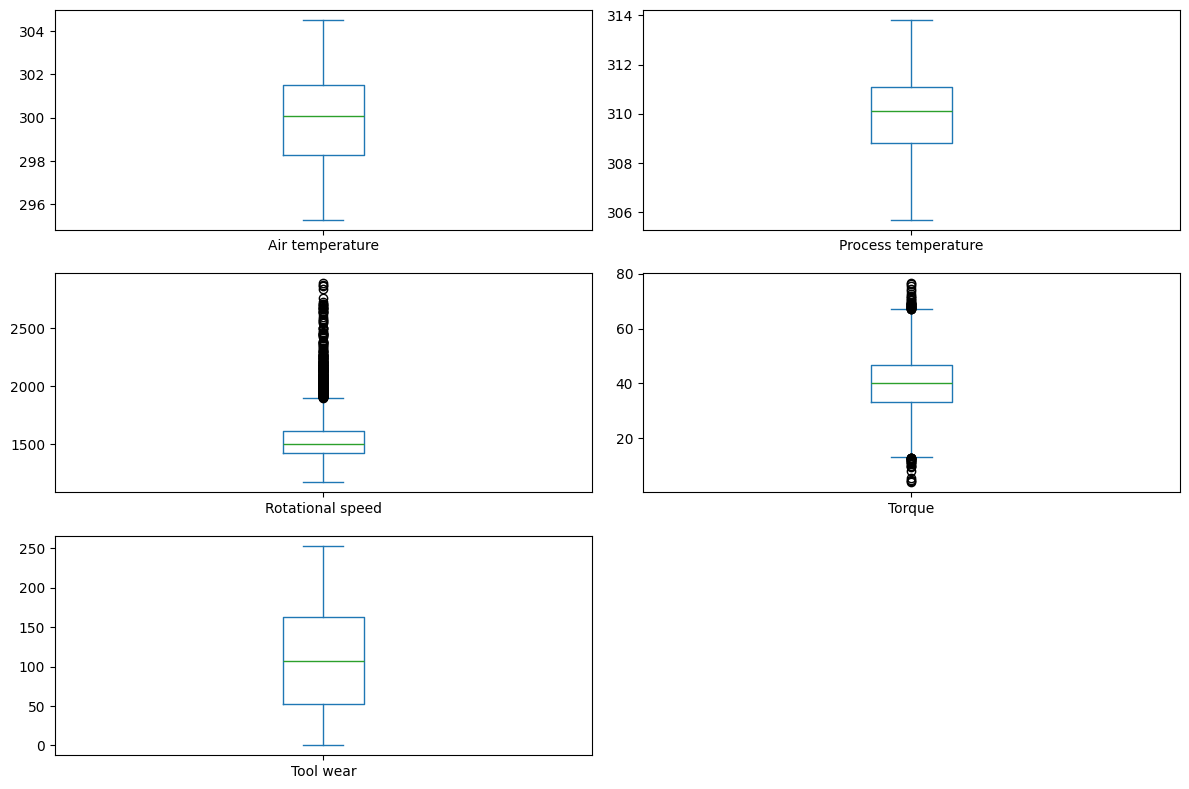

In [19]:
# boxplot distribution
data_train[features].plot(kind = 'box',
                          subplots = True,
                          layout = (3, 2),
                          figsize = (12, 8),
                          sharex = False)
plt.tight_layout()
plt.show()

In [20]:
# outlier detection with IQR method
def iqr_outlier(data, feature):
  Q1 = data[feature].quantile(0.25)
  Q3 = data[feature].quantile(0.75)

  IQR = Q3 - Q1

  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  outliers = data[(data[feature] < lower_bound) | (data[feature] > upper_bound)]

  return outliers, lower_bound, upper_bound

In [21]:
# outlier checking for features
for i in features:
  print(f'{i}:')
  outliers = iqr_outlier(data_train, i)
  print(f'%Outlier: {len(outliers[0])/len(data):.2%}, Lower bound: {outliers[1]}, Upper bound: {outliers[2]}')
  print('')

Air temperature:
%Outlier: 0.00%, Lower bound: 293.5, Upper bound: 306.29999999999995

Process temperature:
%Outlier: 0.00%, Lower bound: 305.35, Upper bound: 314.55000000000007

Rotational speed:
%Outlier: 3.31%, Lower bound: 1135.5, Upper bound: 1899.5

Torque:
%Outlier: 0.56%, Lower bound: 12.800000000000011, Upper bound: 67.19999999999999

Tool wear:
%Outlier: 0.00%, Lower bound: -112.0, Upper bound: 328.0



**Insight about outlier**
- High-value outliers in `Rotational speed` are frequently linked to power failures and will be retained
- Since `Torque` follows a near-normal distribution, outliers may exist in both lower and upper tails, which could negatively impact the stability and performance of linear model

<font color = 'blue'> **Key Takeaways** <br>

- To ensure model robustness, we will use RobustScaler for feature `Rotational speed` standardization
- Given the low outlier rate (0.7%) of `Torque`, we will use capping with thresholds set at the 1st and 99th percentiles

### Data Leakage and Anomaly Checking

Are there any rows where `Machine failure` = 1 even though all failure types are 0?

In [22]:
# check if there are any rows where Machine failure = 1 even though all failure types are 0
anomaly = data_train[(data_train['Machine failure'] == 1) & (data_train[failure_types].sum(axis = 1) == 0)]
anomaly

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
2749,M,299.7,309.2,1685,28.9,179,1,0,0,0,0,0
5941,L,300.6,310.7,1438,48.5,78,1,0,0,0,0,0
4684,M,303.6,311.8,1421,44.8,101,1,0,0,0,0,0
4044,M,301.9,310.9,1419,47.7,20,1,0,0,0,0,0
6478,L,300.5,309.8,1663,29.1,145,1,0,0,0,0,0
1437,H,298.8,309.9,1439,45.2,40,1,0,0,0,0,0
5536,M,302.3,311.8,1363,54.0,119,1,0,0,0,0,0


Unexpected machine failures can occur during live operations; thus, these anomalies will be kept in the dataset.

## Bivariate analysis

### Correlation between each features

In [23]:
# bivariate correlation for numerical features
data_train[features].corr()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear
Air temperature,1.000000,0.876110,0.024841,-0.014754,0.009926
Process temperature,0.876110,1.000000,0.017961,-0.012489,0.012418
Rotational speed,0.024841,0.017961,1.000000,-0.874102,0.002488
Torque,-0.014754,-0.012489,-0.874102,1.000000,-0.007968
Tool wear,0.009926,0.012418,0.002488,-0.007968,1.000000


**Insight about features correlation** <br>
There are features that have a correlation higher than 0.8:
- corr( `Air temperature`, `Process temperature` ) = 0.88
- corr( `Rotational speed`, `Torque` ) = 0.87

<font color = 'blue'> **Key Takeaways** <br>

We should either drop one of the redundant features or perform feature transformation to mitigate multicollinearity

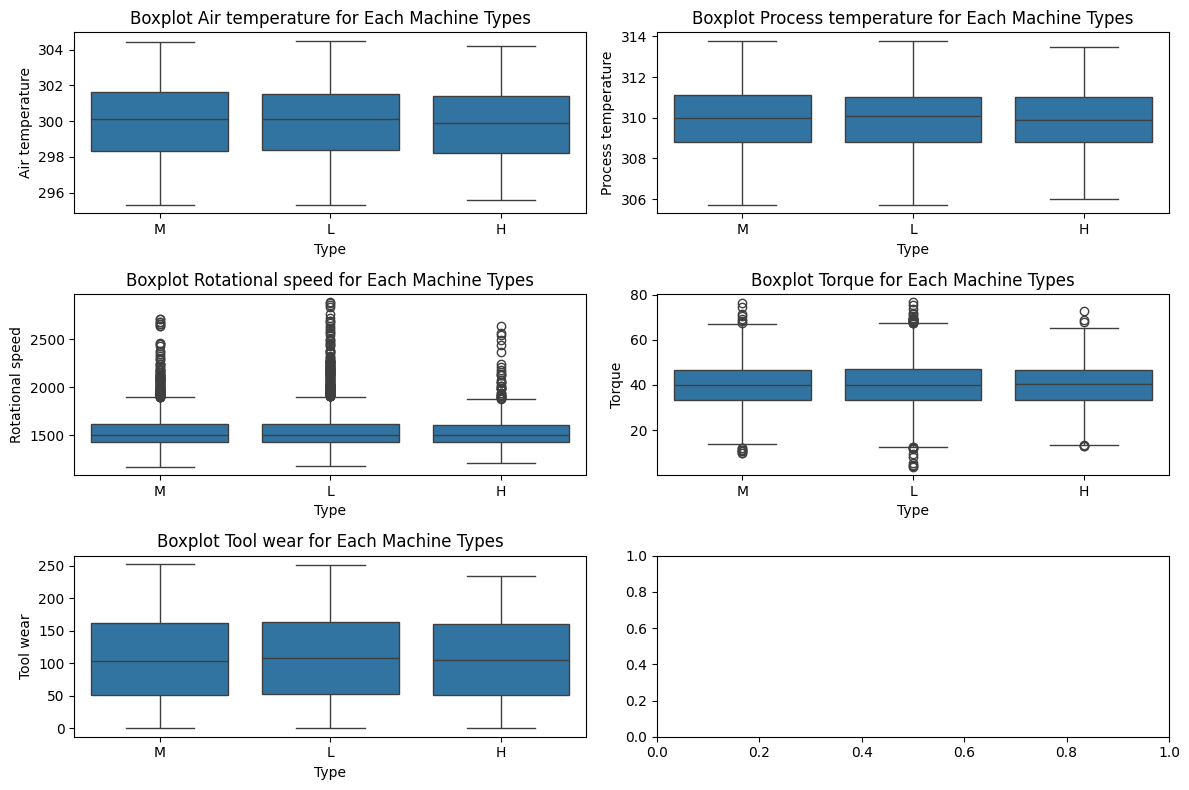

In [24]:
# correlation between machine type and other features
fig, axes = plt.subplots(nrows = 3, ncols = 2, figsize = (12, 8))
axes = axes.flatten()

for i, col in enumerate(features):
  sns.boxplot(data = data_train, x = categorical, y = col, ax = axes[i])

  axes[i].set_title(f'Boxplot {col} for Each Machine Types')

plt.tight_layout()
plt.show()

In [25]:
# one-way anova (F-test)

# hypothesis
# h0 : mu_L = mu_M = mu_H
# h1 : at least one machine type has a mean that is significantly different from the others

from scipy.stats import f_oneway

# calculate p-value
for i in features:
  f_stat, p_val = f_oneway(data_train[data_train['Type'] == 'L'][i],
                           data_train[data_train['Type'] == 'M'][i],
                           data_train[data_train['Type'] == 'H'][i])
  print(f'{i}')
  print(f'p-value = {p_val:.4f}')

  if p_val < 0.05:
    print('Reject H0')
  else:
    print('Fail to reject H0')

  print('')

Air temperature
p-value = 0.2330
Fail to reject H0

Process temperature
p-value = 0.4910
Fail to reject H0

Rotational speed
p-value = 0.9796
Fail to reject H0

Torque
p-value = 0.7965
Fail to reject H0

Tool wear
p-value = 0.3982
Fail to reject H0



**Insight from bivariate analysis between `Type` and features** <br>

ANOVA and Box Plot analysis reveal that all features are consistently distributed across all Machine Types. Consequently, it is (L, M, H) do not significantly impact these operational parameters (features).

### What factors affect machine failure and its types?

**Features vs `Machine failure`**

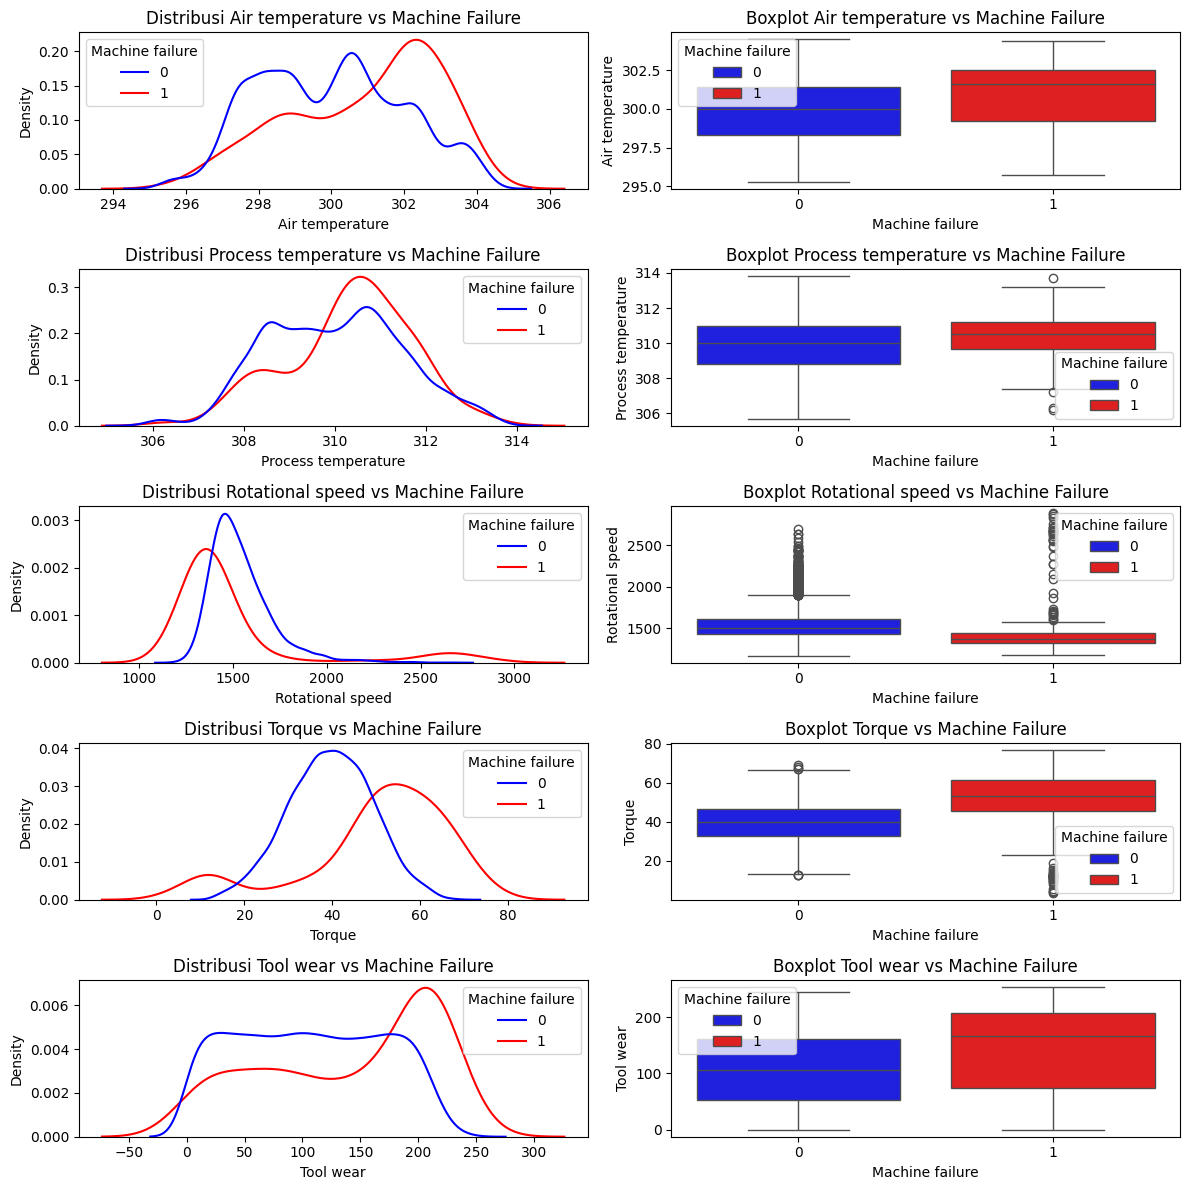

In [26]:
# distribution plot
fig, axes = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 12), squeeze = False)
palette = {0 : 'blue', 1 : 'red'}

for i, col in enumerate(features):
  # kde plot
  sns.kdeplot(data = data_train, x = col, hue = 'Machine failure', fill = False,
              ax = axes[i, 0], palette = palette, common_norm = False)

  axes[i, 0].set_title(f'Distribusi {col} vs Machine Failure')

  # box plot
  sns.boxplot(data = data_train, x = 'Machine failure', y = col, ax = axes[i, 1],
              hue = 'Machine failure', palette = palette)

  axes[i, 1].set_title(f'Boxplot {col} vs Machine Failure')

plt.tight_layout()
plt.show()

In [27]:
# point-biserial correlation
correlation_matrix = data_train[features + ['Machine failure']].corr(method = 'pearson')
failure_corr = correlation_matrix['Machine failure'].sort_values(ascending = False)
failure_corr

,Machine failure
Machine failure,1.000000
Torque,0.190034
Tool wear,0.099214
Air temperature,0.086001
Process temperature,0.040849
Rotational speed,-0.039966


**Insight from bivariate analysis between features and `Machine failure`**
- In general, every features exerts some influence on machine failure
- `Torque` is the most significant positive predictor; `Machine failure` probability is positively correlated with increased torque levels
- However, the correlation strength for each independent feature is relatively weak

<font color = 'blue'> **Key Takeaways** <br>

- Perform feature transformations to capture potential interactions that individual correlations might miss
- Handle the imbalanced class distribution, as the extreme minority of failure cases tends to suppress correlation coefficients toward zero

**Categorical vs `Machine failure`**

In [28]:
# percentage failure for each type
percent_type_failure = pd.crosstab(data_train['Type'], data_train['Machine failure'], normalize = 'index') * 100
percent_type_failure

Machine failure,0,1
Type,,
H,97.972117,2.027883
L,95.921325,4.078675
M,97.564049,2.435951


In [29]:
# chi-square test of independence between Type vs Machine failure
from scipy.stats import chi2_contingency

# contigency table
contingency_table = pd.crosstab(data_train['Type'], data_train['Machine failure'])

# chi-square test
chi2, p_val, dof, expected = chi2_contingency(contingency_table)

print(f'chi-squared statistics: {chi2:.4f}')
print(f'p-value = {p_val:.4f}')

if p_val < 0.05:
  print('Reject H0')
else:
  print('Fail to reject H0')

chi-squared statistics: 18.0942
p-value = 0.0001
Reject H0


**Insight from bivariate analysis between Type and Machine failure**
- Machine `Type` has a statistically significant impact on `Machine failure`
- Highest failure rate observed in machine `Type` L (Low; 4.01%)

### Distribution for each failure modes

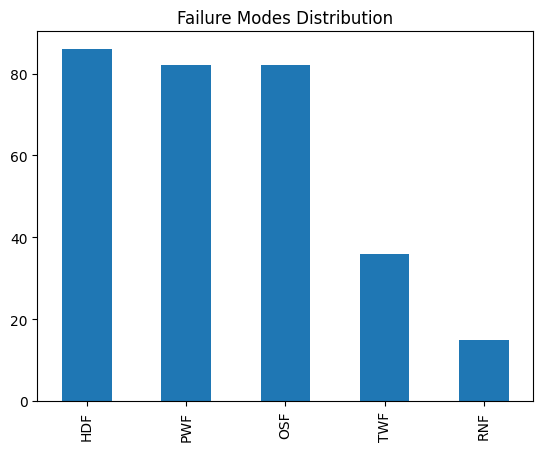

In [30]:
# contribution from each failure modes
data_train[failure_types].sum().plot(kind = 'bar', title = 'Failure Modes Distribution')
plt.show()

In [31]:
# heatmap correlation
corr_matrix = data_train[features + failure_types].corr()
corr_failure_types = corr_matrix.loc[features, failure_types]
corr_failure_types

,HDF,PWF,OSF,TWF,RNF
Air temperature,0.133209,0.003949,0.015323,0.012911,0.013629
Process temperature,0.053734,-0.006793,0.018878,0.011718,0.019550
Rotational speed,-0.116228,0.117730,-0.106192,0.011075,-0.013545
Torque,0.133871,0.091642,0.187318,-0.014879,0.019856
Tool wear,-0.006477,-0.012295,0.159868,0.115193,0.003940


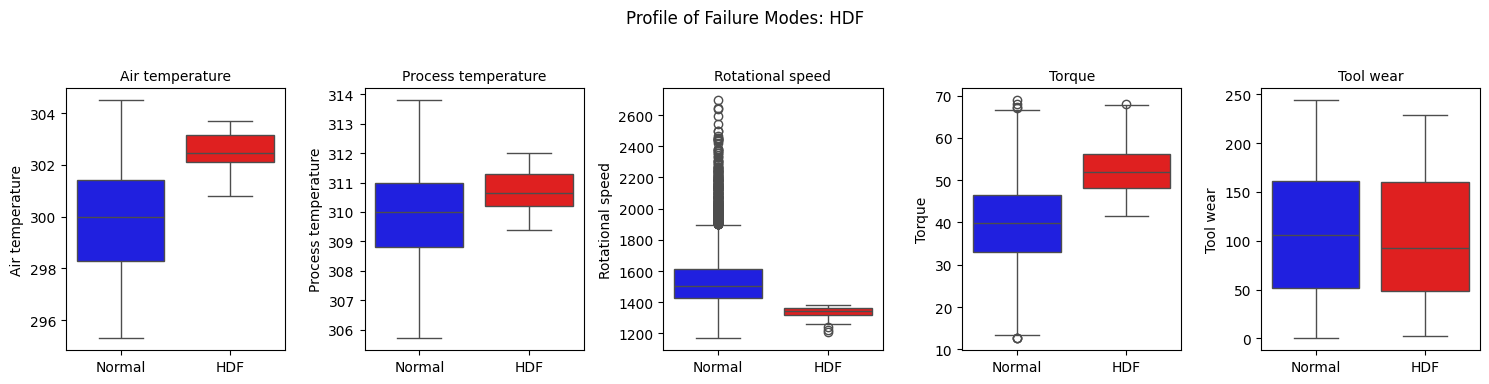

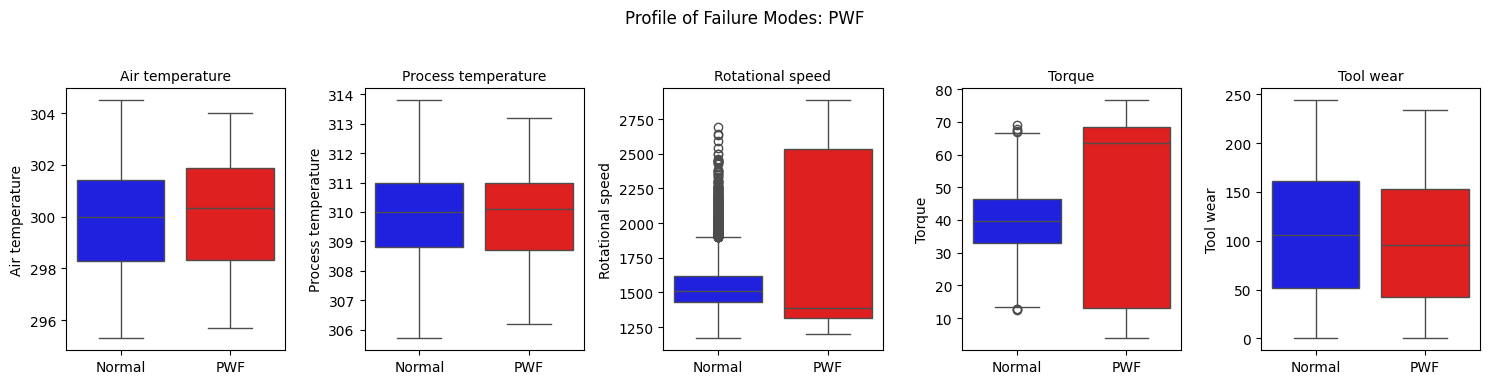

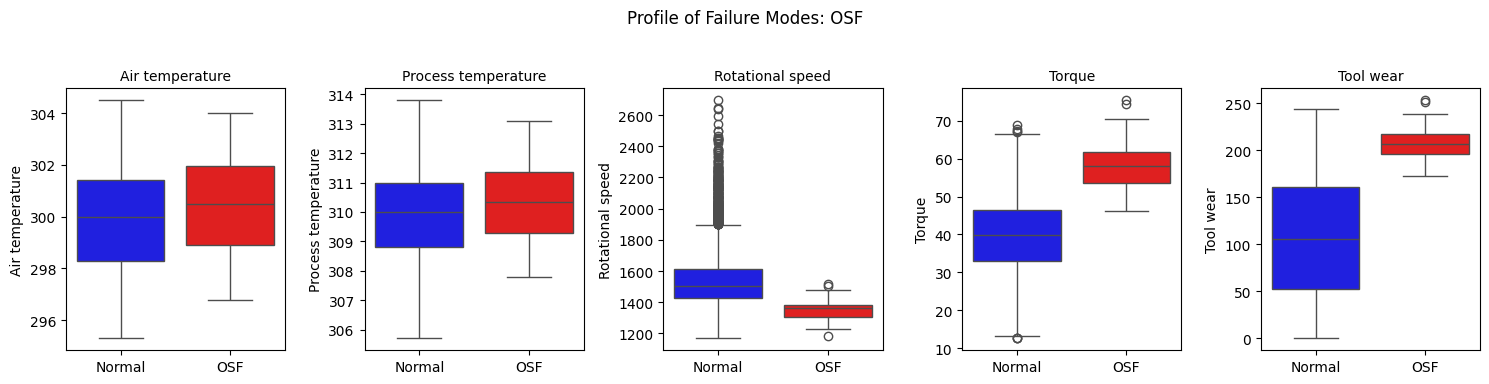

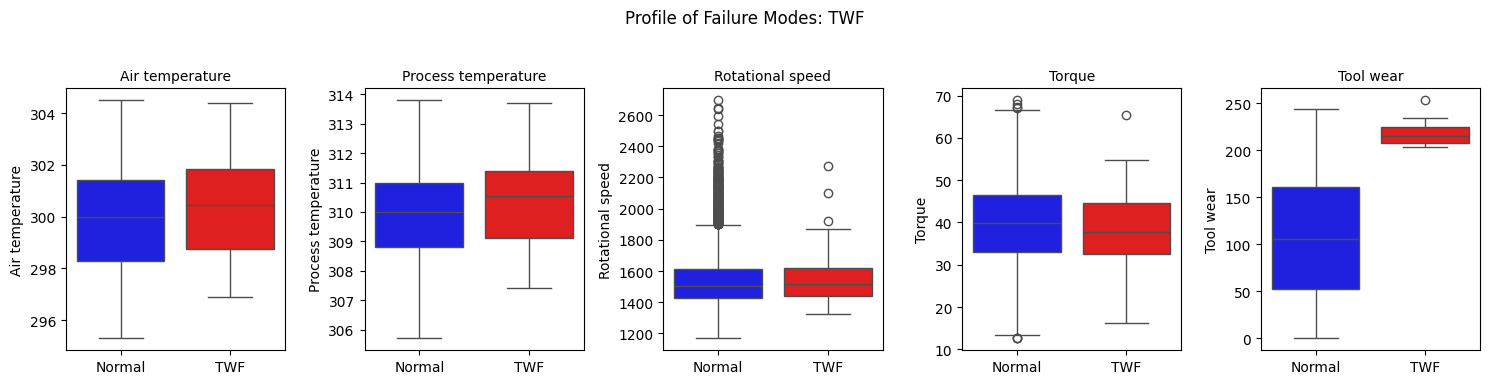

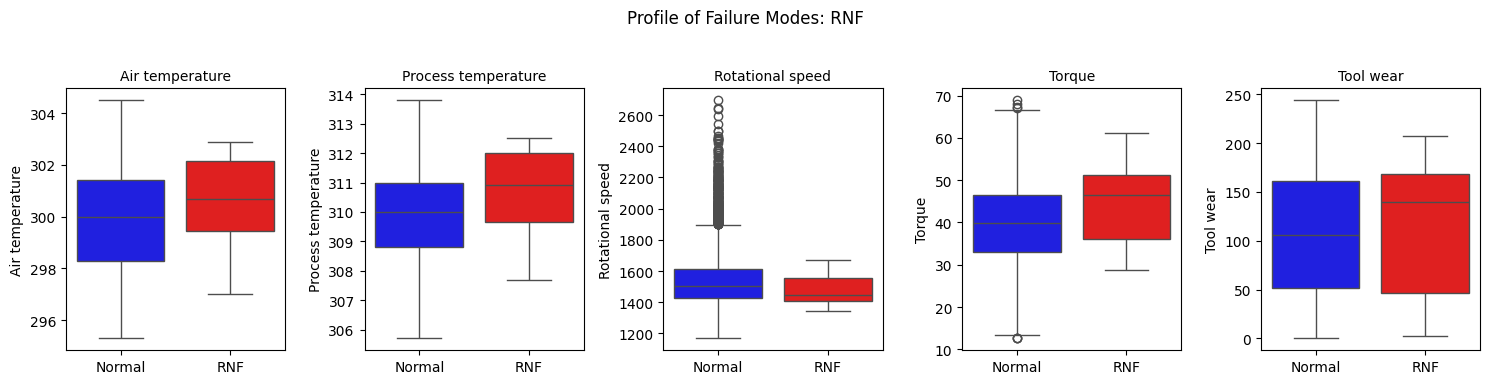

In [32]:
# failure types profiling

def profile_failure_types(data, failure_types):
  data_compare = data_train[(data_train['Machine failure'] == 0) | (data_train[failure_types] == 1)].copy()
  data_compare['Status'] = data_compare[failure_types].apply(lambda x: failure_types if x == 1 else 'Normal')

  # visualization
  fig, axes = plt.subplots(1, len(features), figsize = (15, 4))
  fig.suptitle(f'Profile of Failure Modes: {failure_types}')

  for i, feature in enumerate(features):
    sns.boxplot(data = data_compare, x = 'Status', y = feature, ax = axes[i], hue = 'Status', palette = {'Normal' : 'blue', failure_types : 'red'})
    axes[i].set_title(feature, size = 10)
    axes[i].set_xlabel('')

  plt.tight_layout(rect = [0, 0.03, 1, 0.95])
  plt.show()

for i in failure_types:
  profile_failure_types(data_train, i)
  print('')

**Insight**

<center>

|Failure type|Definition|Influencers|Insight from Boxplot|
|:---|:---|:---|:---|
|`HDF`|Failure caused by the machine's inability <br> to release heat generated during operation|`Air temperature` and `Process temperature`|$\uparrow$ Temperature & Torque (Directly proportional) <br> $\downarrow$ Rotational speed (Inversely proportional)|
|`PWF`|Failure related to the mechanical power <br> produced by the machine's motor|Power (`Power` and `Rotational speed`)|$\uparrow$ Rotational speed <br> Extreme Torque values (either too high or too low)|
|`OSF`|Failure caused by excessive load or material tension <br> that exceeds the machine's physical limits|Strain (`Tool wear` and `Torque`)|$\uparrow$ Torque & Tool wear <br> $\downarrow$ Rotational speed|
|`TWF`|Failure caused by the end of the tool's lifespan <br> or damage to the main cutting component|Time (`Tool wear`)|$\uparrow$ Tool wear|
|`RNF`|Failures that are random and not directly linked <br> to the available sensor parameters|Random, probability|No clear pattern was observed|

</center>


Notes: <br>
When the boxplot for a specific failure type (red) is positioned higher and does not overlap with the normal status (blue), it indicates a stark contrast between normal and failure states influenced by that feature.

<font color = 'blue'> **Key Takeaways** <br>

Do the feature transformation using information given above:
- Temperature difference $(K)$ <br>
`Delta T` = `Process temperature` - `Air temperature`
- Mechanical power $(rad/s)$ <br>
`Power` = `Torque` $ \times $ `Rotational speed` $ \times \frac{2\pi}{60}$
- Strain index $minNM$ <br>
`Strain` = `Torque` $ \times $ `Tool wear`

Consequently, we can eliminate redundancies between highly correlated features such as `Air temperature` vs `Process temperature` and `Torque` vs `Rotational speed`

**How about Machine Types vs Failure Types**

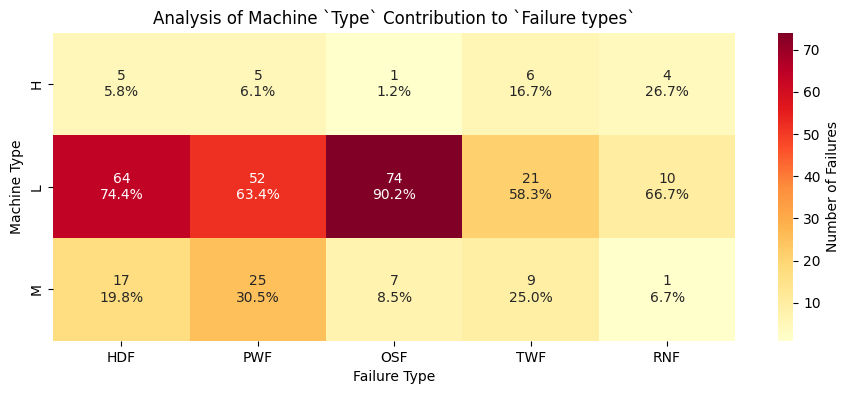

In [33]:
# contigency table
machine_vs_failure = data_train.groupby('Type')[failure_types].sum()
machine_vs_failure

# contribution percentage for each column (Failure type)
contribution_percentage = machine_vs_failure.div(machine_vs_failure.sum(axis = 0), axis = 1) * 100

plt.figure(figsize = (11, 4))

# annotation: numbers of failure and contribution percentage
labels = (machine_vs_failure.astype(str) + '\n' + contribution_percentage.round(1).astype(str) + '%').values

sns.heatmap(machine_vs_failure, annot = labels, fmt = '', cmap = 'YlOrRd', cbar_kws = {'label': 'Number of Failures'})
plt.title('Analysis of Machine `Type` Contribution to `Failure types`')
plt.ylabel('Machine Type')
plt.xlabel('Failure Type')
plt.show()

HDF | chi-2: 7.2027 | p-value = 0.0273 | Reject H0
PWF | chi-2: 1.3322 | p-value = 0.5137 | Fail to reject H0
OSF | chi-2: 31.0593 | p-value = 0.0000 | Reject H0
TWF | chi-2: 1.9981 | p-value = 0.3682 | Fail to reject H0
RNF | chi-2: 7.0948 | p-value = 0.0288 | Reject H0


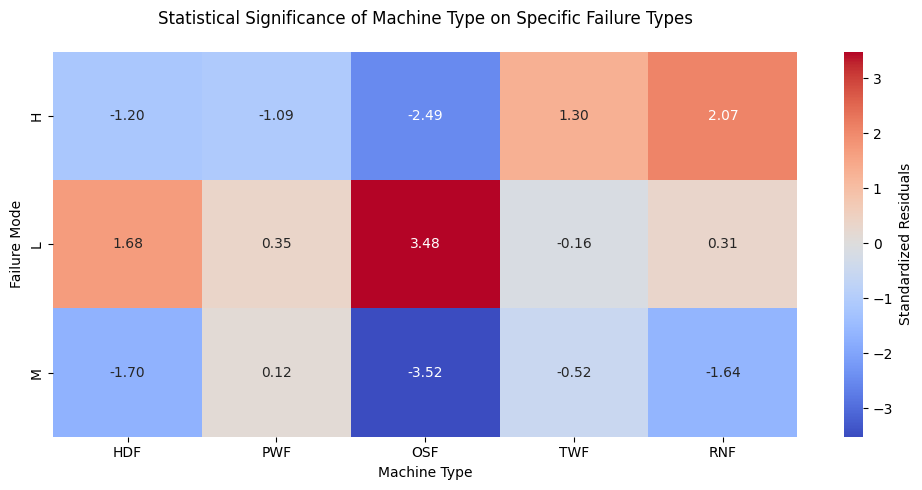

In [34]:
# chi-squared and residual (use when H0 rejected) analysis

from scipy.stats import chi2_contingency

all_residuals = pd.DataFrame()

for col in failure_types:
  contigency_table = pd.crosstab(data_train['Type'], data_train[col])

  chi2, p, dof, expected = chi2_contingency(contigency_table)
  output = 'Reject H0' if p < 0.05 else 'Fail to reject H0'

  residual = (contigency_table - expected) / np.sqrt(expected)
  all_residuals[col] = residual[1]

  print(f'{col:4}| chi-2: {chi2:.4f} | p-value = {p:.4f} | {output}')

# residual visualization
plt.figure(figsize = (12, 5))
sns.heatmap(all_residuals, cmap = 'coolwarm', annot = True, fmt = '.2f', cbar_kws = {'label': 'Standardized Residuals'})
plt.title('Statistical Significance of Machine Type on Specific Failure Types', pad = 20)
plt.xlabel('Machine Type')
plt.ylabel('Failure Mode')
plt.show()

**Insight**

Since Machine `Type` is statistically significant for `HDF`, `OSF`, and `RNF`, we will use standardized residuals to identify which specific types are the primary contributors to these failures.

- High Positive Residual (> 2): Indicates that this machine type has a significant vulnerability toward that specific failure types

- High Negative Residual (< -2): Indicates that this machine type is highly resilient and rarely experiences that specific failure types

<center>

|Failure|Highest <br> Frequency|Most Significant <br> (Residuals)|
|---|---|---|
|`HDF`|<center> L|<center> L|
|`PWF`|<center> L||
|`OSF`|<center> L|<center> L|
|`TWF`|<center> L||
|`RNF`|<center> L|<center> H|

</center>

# <font color = 'blue'> Data Preprocessing
---

## Data Preparation

Including handling duplicates, missing value, and outlier.

- Input: raw data (`data_train` and `data_test`)
- Output: cleaned data (`cleaned_train` and `cleaned_test`)

In [35]:
def data_preparation(input_data):

  data = input_data.copy()

  # divide column into different category
  failure_types = ['HDF', 'PWF', 'OSF', 'TWF', 'RNF']
  target = 'Machine failure'
  categorical = 'Type'
  features = [col for col in data.columns if col not in [target, categorical] + failure_types]

  # handling duplicate value: drop
  initial_shape = data.shape[0]
  data.drop_duplicates(inplace = True)
  drop_status = True if initial_shape > data.shape[0] else False

  # handling missing value: imputation
  '''
  Numerical features are imputed with the mean,
  except for the skewed Rotational speed (median),
  while categorical and boolean features are imputed using the mode.
  '''
  has_missing = data.isnull().values.any()
  if has_missing:
    for col in features:
      if col == 'Rotational speed':
        data[col].fillna(data[col].median(), inplace = True)
      else:
        data[col].fillna(data[col].mean(), inplace = True)

    for col in [categorical] + failure_types + target:
      data[col].fillna(data[col].mode()[0], inplace = True)

    imputation_status = 'Completed'
  else:
    imputation_status = 'No Missing Values'

  # handling outlier
  '''
  Torque: Capping with thresholds set at the 1st and 99th percentiles
  '''
  initial_min = data['Torque'].min()
  initial_max = data['Torque'].max()

  lower_bound = data['Torque'].quantile(0.01)
  upper_bound = data['Torque'].quantile(0.99)
  data.loc[data['Torque'] < lower_bound, 'Torque'] = lower_bound
  data.loc[data['Torque'] > upper_bound, 'Torque'] = upper_bound

  new_min = data['Torque'].min()
  new_max = data['Torque'].max()

  handling_outlier = True if (initial_min < new_min) or (initial_max > new_max) else False

  # summary
  prep_summary = {
      'Drop duplicates' : drop_status,
      'Imputation' : imputation_status,
      'Handling outlier' : handling_outlier
  }

  return data, prep_summary

### on data_train

In [36]:
cleaned_train, prep_summary_train = data_preparation(data_train)
prep_summary_train

{'Drop duplicates': False,
 'Imputation': 'No Missing Values',
 'Handling outlier': True}

In [37]:
cleaned_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8000 entries, 4058 to 1424
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 8000 non-null   object 
 1   Air temperature      8000 non-null   float64
 2   Process temperature  8000 non-null   float64
 3   Rotational speed     8000 non-null   int64  
 4   Torque               8000 non-null   float64
 5   Tool wear            8000 non-null   int64  
 6   Machine failure      8000 non-null   int64  
 7   TWF                  8000 non-null   int64  
 8   HDF                  8000 non-null   int64  
 9   PWF                  8000 non-null   int64  
 10  OSF                  8000 non-null   int64  
 11  RNF                  8000 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 812.5+ KB


In [38]:
cleaned_train.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
4058,M,302.0,310.9,1456,47.2,54,0,0,0,0,0,0
1221,M,297.0,308.3,1399,46.4,132,0,0,0,0,0,1
6895,M,301.0,311.6,1357,45.6,137,0,0,0,0,0,0
9863,L,298.9,309.8,1411,56.3,84,0,0,0,0,0,0
8711,L,297.1,308.5,1733,28.7,50,0,0,0,0,0,0


In [39]:
cleaned_train.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.00000,8000.000000,8000.000000,8000.000000
mean,300.005450,310.006062,1539.356875,39.993027,107.685000,0.033875,0.004500,0.01075,0.010250,0.010250,0.001875
std,1.996844,1.479432,180.982943,9.835113,63.612002,0.180919,0.066935,0.10313,0.100728,0.100728,0.043263
min,295.300000,305.700000,1168.000000,16.599000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,298.300000,308.800000,1422.000000,33.200000,53.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,107.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
75%,301.500000,311.100000,1613.000000,46.800000,163.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
max,304.500000,313.800000,2886.000000,62.900000,253.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000


### on data_test

In [40]:
cleaned_test, prep_summary_test = data_preparation(data_test)
prep_summary_test

{'Drop duplicates': False,
 'Imputation': 'No Missing Values',
 'Handling outlier': True}

In [41]:
cleaned_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 2997 to 9191
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Type                 2000 non-null   object 
 1   Air temperature      2000 non-null   float64
 2   Process temperature  2000 non-null   float64
 3   Rotational speed     2000 non-null   int64  
 4   Torque               2000 non-null   float64
 5   Tool wear            2000 non-null   int64  
 6   Machine failure      2000 non-null   int64  
 7   TWF                  2000 non-null   int64  
 8   HDF                  2000 non-null   int64  
 9   PWF                  2000 non-null   int64  
 10  OSF                  2000 non-null   int64  
 11  RNF                  2000 non-null   int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 203.1+ KB


In [42]:
cleaned_test.head()

,Type,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
2997,L,300.5,309.8,1345,62.301,153,0,0,0,0,0,0
4871,L,303.7,312.4,1513,40.100,135,0,0,0,0,0,0
3858,L,302.5,311.4,1559,37.600,209,0,0,0,0,0,0
951,H,295.6,306.3,1509,35.800,60,0,0,0,0,0,0
6463,H,300.5,310.0,1358,60.400,102,0,0,0,0,0,0


In [43]:
cleaned_test.describe()

,Air temperature,Process temperature,Rotational speed,Torque,Tool wear,Machine failure,TWF,HDF,PWF,OSF,RNF
count,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.00000,2000.00000,2000.000000,2000.000000
mean,300.00285,310.003550,1536.453000,39.915460,109.015000,0.034000,0.005000,0.01450,0.00650,0.008000,0.002000
std,2.01436,1.501193,172.345712,9.582466,63.827296,0.181274,0.070551,0.11957,0.08038,0.089107,0.044688
min,295.30000,305.800000,1202.000000,17.800000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
25%,298.40000,308.900000,1425.000000,33.200000,54.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
50%,300.10000,310.100000,1503.000000,40.000000,112.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
75%,301.50000,311.100000,1609.000000,46.500000,161.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000
max,304.40000,313.600000,2825.000000,62.301000,246.000000,1.000000,1.000000,1.00000,1.00000,1.000000,1.000000


## Feature Engineering

Input: `cleaned_train`, `cleaned_test` <br>
Output: `X_train_original`, `y_train`, `X_test_original`, `y_test`

Including:
- Drop Failure Type features (Data leakage)
- Feature encoding for `Type`
- Feature engineering for:
  - Temperature difference $(K)$ <br>
  `Delta T` = `Process temperature` - `Air temperature`
  - Mechanical power $(rad/s)$ <br>
  `Power` = `Torque` $ \times $ `Rotational speed` $ \times \frac{2\pi}{60}$
  - Strain index $(minNM)$ <br>
  `Strain` = `Torque` $ \times $ `Tool wear`
- Feature scaling (mix)


In [44]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer

with_robust = ['Rotational speed', 'Torque', 'Power', 'Strain']
with_standard = ['Air temperature', 'Process temperature', 'Delta T', 'Tool wear']
with_onehot = ['Type']

preprocessor = ColumnTransformer(
    transformers = [
        ('standard', StandardScaler(), with_standard),
        ('robust', RobustScaler(), with_robust),
        ('onehot', OneHotEncoder(sparse_output = False, drop = 'first'), with_onehot)
    ])

# create categorical target column
def get_failure_type(row):
  if row['TWF'] == 1: return 'TWF'
  elif row['HDF'] == 1: return 'HDF'
  elif row['PWF'] == 1: return 'PWF'
  elif row['OSF'] == 1: return 'OSF'
  elif row['RNF'] == 1: return 'RNF'
  else: return 'No Failure'

# feature engineering
def data_engineering(input_data, train_or_test, target_type):
  '''
  binary      : 1/0
  multiclass  : failure_types
  '''

  data = input_data.copy()

  # feature engineering
  data['Delta T'] = data['Process temperature'] - data['Air temperature']
  data['Power'] = data['Torque'] * data['Rotational speed'] * 2 * np.pi / 60
  data['Strain'] = data['Torque'] * data['Tool wear']

  # target y and features X
  if target_type == 'binary':
    y = data[target]

    to_drop = [target] + failure_types
    X = data.drop(to_drop, axis = 1)

  else:
    # we will work only with failure rows in multiclass
    data = data[data[target] == 1]

    y = data.apply(get_failure_type, axis = 1)
    y = pd.DataFrame(y, columns = ['Failure type'])

    to_drop = failure_types + [target]
    X = data.drop(to_drop, axis = 1)

  # feature transformation here
  global preprocessor

  if train_or_test == 'train':
    transform_data = preprocessor.fit_transform(X)

  if train_or_test == 'test':
    transform_data = preprocessor.transform(X)

  # create new dataframe
  col_names = with_standard + with_robust + list(preprocessor.named_transformers_['onehot'].get_feature_names_out())
  transformed_data = pd.DataFrame(transform_data, columns = col_names)

  return transformed_data, y

### on data_train

In [45]:
X_train_original, y_train = data_engineering(cleaned_train,
                                             train_or_test = 'train',
                                             target_type = 'binary')
X_train_original.head()

,Air temperature,Process temperature,Delta T,Tool wear,Rotational speed,Torque,Power,Strain,Type_L,Type_M
0,0.998914,0.604282,-1.100842,-0.843997,-0.246073,0.522059,0.635637,-0.336432,0.0,1.0
1,-1.505194,-1.153260,1.299658,0.382263,-0.544503,0.463235,0.361312,0.494109,0.0,1.0
2,0.498092,1.077466,0.599512,0.460870,-0.764398,0.404412,0.142808,0.522537,0.0,1.0
3,-0.553633,-0.139294,0.899575,-0.372359,-0.481675,1.191176,1.407291,0.169975,1.0,0.0
4,-1.455112,-1.018064,1.399679,-0.906882,1.204188,-0.838235,-0.731531,-0.595116,1.0,0.0


In [46]:
y_train.head()

,Machine failure
4058,0
1221,0
6895,0
9863,0
8711,0


In [47]:
# for future feature selection (in machine learning modeling)
X_train_original.corr()

,Air temperature,Process temperature,Delta T,Tool wear,Rotational speed,Torque,Power,Strain,Type_L,Type_M
Air temperature,1.000000,0.876110,-0.700802,0.009926,0.024841,-0.015315,-0.013133,0.004570,0.007715,0.004193
Process temperature,0.876110,1.000000,-0.270062,0.012418,0.017961,-0.013210,-0.011161,0.006985,0.004097,0.004263
Delta T,-0.700802,-0.270062,1.000000,-0.001450,-0.023035,0.011041,0.009713,0.001209,-0.009345,-0.002067
Tool wear,0.009926,0.012418,-0.001450,1.000000,0.002488,-0.008784,-0.009514,0.899583,0.015129,-0.011463
Rotational speed,0.024841,0.017961,-0.023035,0.002488,1.000000,-0.866950,-0.776978,-0.322058,-0.000197,0.001504
Torque,-0.015315,-0.013210,0.011041,-0.008784,-0.866950,1.000000,0.976606,0.368372,0.007339,-0.005791
Power,-0.013133,-0.011161,0.009713,-0.009514,-0.776978,0.976606,1.000000,0.359312,0.010785,-0.009502
Strain,0.004570,0.006985,0.001209,0.899583,-0.322058,0.368372,0.359312,1.000000,0.019990,-0.016421
Type_L,0.007715,0.004097,-0.009345,0.015129,-0.000197,0.007339,0.010785,0.019990,1.000000,-0.803515
Type_M,0.004193,0.004263,-0.002067,-0.011463,0.001504,-0.005791,-0.009502,-0.016421,-0.803515,1.000000


<font color = 'blue'> **Key Takeaways** <br>

There are feature with high correlation values, such as:
- `Air temperature` and `Process temperature` (0.8761)
- `Tool wear` and `Strain` (0.8996)
- `Rotational speed` and `Torque` (-0.8669)
- `Rotational speed` and `Power` (-0.7770)
- `Torque` and `Power` (0.9766)

Thus for linear modeling (Logistic Regression and SVM), we will use feature selection:
- Drop `Air temperature`, `Process temperature`, `Rotational speed`, `Torque`, `Tool wear`

### on data_test

In [48]:
X_test_original, y_test = data_engineering(cleaned_test,
                                           train_or_test = 'test',
                                           target_type = 'binary')
X_test_original.head()

,Air temperature,Process temperature,Delta T,Tool wear,Rotational speed,Torque,Power,Strain,Type_L,Type_M
0,0.247681,-0.139294,-0.700758,0.712410,-0.827225,1.632426,1.720929,1.285457,1.0,0.0
1,1.850310,1.618248,-1.300884,0.429427,0.052356,0.000000,0.055828,0.328907,1.0,0.0
2,1.249324,0.942270,-1.100842,1.592802,0.293194,-0.183824,-0.091999,0.896745,1.0,0.0
3,-2.206344,-2.505215,0.699533,-0.749670,0.031414,-0.316176,-0.422966,-0.429519,0.0,0.0
4,0.247681,-0.004098,-0.500717,-0.089376,-0.759162,1.492647,1.593355,0.502470,0.0,0.0


In [49]:
y_test.head()

,Machine failure
2997,0
4871,0
3858,0
951,0
6463,0


# <font color = 'blue'> Supervised Modelling
---

## Handling imbalance dataset

Input: `X_train_original`, `y_train`, `X_test_original`, `y_test` <br>
Output: `X_rus`, `y_rus`, `X_res`, `y_res`

In [50]:
## target percentage
y_train.value_counts(normalize = True)

,proportion
Machine failure,
0,0.966125
1,0.033875


In [51]:
# dataset used for modeling
def dataset_used(data, feature_to_drop):
  data = data.drop(feature_to_drop, axis = 1)
  return data

feature_to_drop = []
# feature_to_drop = ['Air temperature', 'Process temperature', 'Torque', 'Tool wear']

# data used for modeling
X_train = dataset_used(X_train_original, feature_to_drop)
X_test = dataset_used(X_test_original, feature_to_drop)

In [52]:
# sampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

def resample_data(X, y):

  # RandomUnderSampler
  rus = RandomUnderSampler(random_state = 42)
  X_rus, y_rus = rus.fit_resample(X, y)

  # RandomOverSampler
  ros = RandomOverSampler(random_state = 42)
  X_res, y_res = ros.fit_resample(X_rus, y_rus)

  return X_rus, y_rus, X_res, y_res

In [53]:
X_rus, y_rus, X_res, y_res = resample_data(X_train, y_train)

## Machine Learning Modeling

### Baseline Model

In [54]:
# import libraries here

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [55]:
# baseline check with cross-val
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)

def perfom_baseline_model(X, y, dataset_statue):

  # imbalace ratio (y == 0 / y == 1)
  cw_param = 'balanced' if dataset_statue == 'imbalance' else None
  class_ratio = float(y.value_counts()[0] / y.value_counts()[1]) if dataset_statue == 'imbalance' else 1

  # define baseline model
  models = {
      'Logistic Regression' : LogisticRegression(class_weight = cw_param, max_iter = 1000, random_state = 42),
      'SVM' : SVC(class_weight = cw_param, probability = True, kernel = 'linear', random_state = 42),

      'KNN' : KNeighborsClassifier(n_neighbors = 5),

      'Decision Tree' : DecisionTreeClassifier(class_weight = cw_param, random_state = 42),
      'Random Forest' : RandomForestClassifier(class_weight = cw_param, random_state = 42),
      'XGBoost' : XGBClassifier(scale_pos_weight = class_ratio)
  }

  # perform model
  results = []
  names = []

  print('-----Baseline Performance (F1-Score Mean)-----')

  for name, model in models.items():
    cv_scores = cross_val_score(model, X, y, cv = skf, scoring = 'f1', n_jobs = -1)

    results.append(cv_scores)
    names.append(name)

    print(f'{name:20} : {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})')

  print('')

  # result visualization
  plt.figure(figsize = (8, 4))
  plt.boxplot(results, labels = names)
  plt.title('Baseline Performance Comparison (F1-Score)')
  plt.ylabel('F1-Score')
  plt.show()

  return models

-----Baseline Performance (F1-Score Mean)-----
Logistic Regression  : 0.2668 (+/- 0.0124)
SVM                  : 0.2648 (+/- 0.0101)
KNN                  : 0.4375 (+/- 0.0475)
Decision Tree        : 0.6659 (+/- 0.0315)
Random Forest        : 0.7259 (+/- 0.0276)
XGBoost              : 0.7664 (+/- 0.0314)



/tmp/ipython-input-1548650145.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels = names)


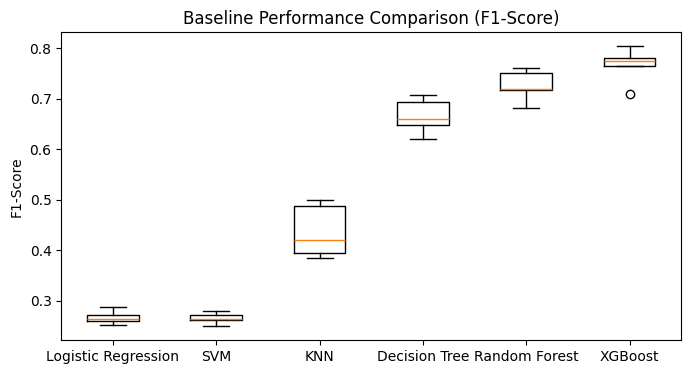

{'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'SVM': SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42),
 'KNN': KNeighborsClassifier(),
 'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, m

In [56]:
# baseline for X_train, y_train
perfom_baseline_model(X_train, y_train, 'imbalance')

-----Baseline Performance (F1-Score Mean)-----
Logistic Regression  : 0.8069 (+/- 0.0288)
SVM                  : 0.8262 (+/- 0.0285)
KNN                  : 0.8734 (+/- 0.0233)
Decision Tree        : 0.9056 (+/- 0.0177)
Random Forest        : 0.9259 (+/- 0.0173)
XGBoost              : 0.9154 (+/- 0.0111)



/tmp/ipython-input-1548650145.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels = names)


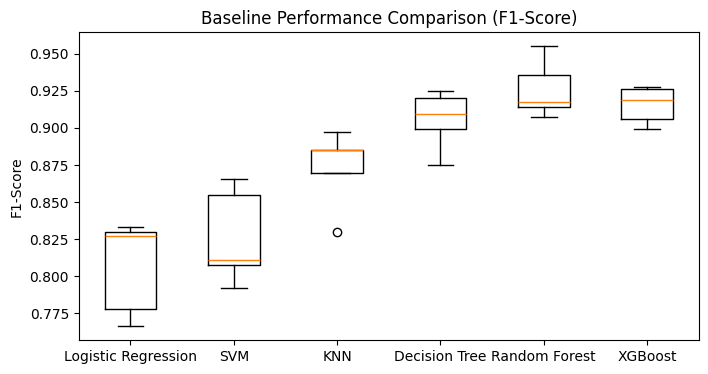

{'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
 'SVM': SVC(kernel='linear', probability=True, random_state=42),
 'KNN': KNeighborsClassifier(),
 'Decision Tree': DecisionTreeClassifier(random_state=42),
 'Random Forest': RandomForestClassifier(random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_

In [57]:
# baseline for X_rus, y_rus
perfom_baseline_model(X_rus, y_rus, 'balance')

-----Baseline Performance (F1-Score Mean)-----
Logistic Regression  : 0.8069 (+/- 0.0288)
SVM                  : 0.8262 (+/- 0.0285)
KNN                  : 0.8734 (+/- 0.0233)
Decision Tree        : 0.9043 (+/- 0.0207)
Random Forest        : 0.9259 (+/- 0.0173)
XGBoost              : 0.9154 (+/- 0.0111)



/tmp/ipython-input-1548650145.py:40: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(results, labels = names)


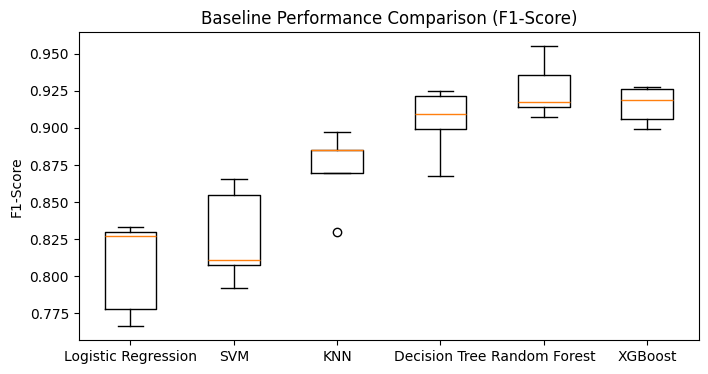

{'Logistic Regression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42),
 'SVM': SVC(class_weight='balanced', kernel='linear', probability=True, random_state=42),
 'KNN': KNeighborsClassifier(),
 'Decision Tree': DecisionTreeClassifier(class_weight='balanced', random_state=42),
 'Random Forest': RandomForestClassifier(class_weight='balanced', random_state=42),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               feature_weights=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=None, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
               max_leaves=None, m

In [58]:
# baseline for X_ros, y_ros
perfom_baseline_model(X_res, y_res, 'imbalance')

### Model selected training: hyperparameter tuning

In [59]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_predict, learning_curve
from sklearn.metrics import precision_recall_curve, average_precision_score

'''
# parameter tuning
random_forest_param = {
    'n_estimators' : [200, 300],
    'max_depth' : [5, 10, 15],
    'min_samples_split' : [20, 40, 80],
    'min_samples_leaf' : [10, 20, 40],
    'max_samples' : [0.6, 0.7, 0.8],
    'max_features' : ['sqrt'],
    'bootstrap' : [True]
}

'''

# parameter tuning
random_forest_param = {
    'n_estimators' : [300, 500],
    'max_depth' : [12, 15, 18],
    'min_samples_split' : [10, 20],
    'min_samples_leaf' : [5, 10],
    'max_samples' : [0.6, 0.7, 0.8],
    'max_features' : ['sqrt'],
    'bootstrap' : [True]
}


In [60]:
print('-----Hyperparameter Tuning (Random Forest)-----')

# RandomizedSearch initialization
random_forest_tuning = RandomizedSearchCV(
    estimator = RandomForestClassifier(class_weight = 'balanced_subsample', random_state = 42),
    param_distributions = random_forest_param,
    n_iter = 10,
    cv = skf,
    scoring = 'f1',
    n_jobs = -1,
    random_state = 42
)

# fitting to data
random_forest_tuning.fit(X_train, y_train)

# best model and its parameters
best_rf_model = random_forest_tuning.best_estimator_
print('Best Parameters:', random_forest_tuning.best_params_)
print('')

# is it overfitting?
y_train_pred = best_rf_model.predict(X_train)
train_f1 = f1_score(y_train, y_train_pred)
cv_f1 = random_forest_tuning.best_score_

# std of best cv
best_index = random_forest_tuning.best_index_
cv_std = random_forest_tuning.cv_results_['std_test_score'][best_index]

print(f'F1-Score Train: {train_f1:.4f} | CV: {cv_f1:.4f} (+/- {cv_std:.4f}) | Gap: {train_f1 - cv_f1:.4f}')
print('')

-----Hyperparameter Tuning (Random Forest)-----
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.6, 'max_features': 'sqrt', 'max_depth': 12, 'bootstrap': True}

F1-Score Train: 0.8378 | CV: 0.7650 (+/- 0.0259) | Gap: 0.0729



-----Learning Curve (Random Forest)-----


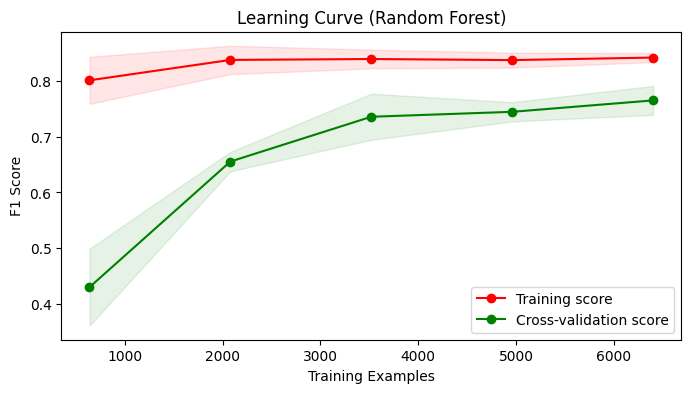

In [61]:
# learning curve
print('-----Learning Curve (Random Forest)-----')
train_sizes, train_scores, test_scores = learning_curve(
    best_rf_model,
    X_train,
    y_train,
    cv = skf,
    scoring = 'f1',
    n_jobs = -1,
    train_sizes = np.linspace(0.1, 1.0, 5)
)

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

plt.figure(figsize = (8, 4))
plt.plot(train_sizes, train_mean, 'o-', color = 'r', label = 'Training score')
plt.plot(train_sizes, test_mean, 'o-', color = 'g', label = 'Cross-validation score')

# standard deviation area
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha = 0.1, color = 'g')

plt.title('Learning Curve (Random Forest)')
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.legend(loc = 'best')
plt.show()

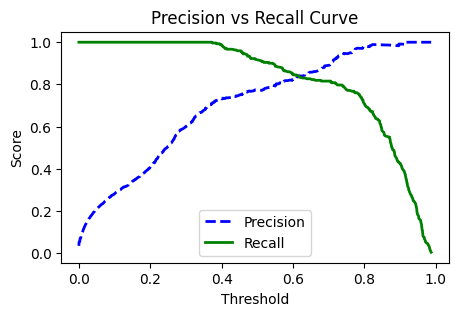

In [62]:
# what threshold to use?
y_probs_train = best_rf_model.predict_proba(X_train)[:, 1]

# threshold to be test
thresholds = np.linspace(0.3, 0.5, 100)
# print(f'{'Threshold':<12} | {'Precision':<10} | {'Recall':<10} | {'F1-Score':<10}')
# print('-' * 50)

for t in thresholds:
    # pick a threshold
    y_pred_t = (y_probs_train >= t).astype(int)

    # metric calculation (focused on class = 1 / failure)
    report = classification_report(y_train, y_pred_t, output_dict = True, zero_division = 0)
    prec = report['1']['precision']
    rec = report['1']['recall']
    f1 = report['1']['f1-score']

#    print(f'{t:<12} | {prec:<10.4f} | {rec:<10.4f} | {f1:<10.4f}')

# plot precision vs recall
precision_vals, recall_vals, thresh_vals = precision_recall_curve(y_train, y_probs_train)

plt.figure(figsize = (5, 3))
plt.plot(thresh_vals, precision_vals[:-1], 'b--', label = 'Precision', linewidth = 2)
plt.plot(thresh_vals, recall_vals[:-1], 'g-', label = 'Recall', linewidth = 2)

plt.title('Precision vs Recall Curve')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend(loc = 'best')
plt.show()

### Final model training and evaluation

In [63]:
# predict the probability in the data test
y_probs_test = best_rf_model.predict_proba(X_test)[:, 1]

# threshold used
final_threshold = 0.4
y_pred_test = (y_probs_test >= final_threshold).astype(int)

# evaluation metrics report
print('-----Evaluation Report (Test Dataset)-----')
print(classification_report(y_test, y_pred_test))

-----Evaluation Report (Test Dataset)-----
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1932
           1       0.76      0.81      0.79        68

    accuracy                           0.98      2000
   macro avg       0.88      0.90      0.89      2000
weighted avg       0.99      0.98      0.99      2000



In [64]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_test))

[[1915   17]
 [  13   55]]


In [65]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_test, average = 'binary', pos_label = 1)

print(f'Recall: {recall*100:.2f}% | Precision: {precision*100:.2f}% | F1-Score: {f1:.4f}')

Recall: 80.88% | Precision: 76.39% | F1-Score: 0.7857


#### Feature importance of modeling

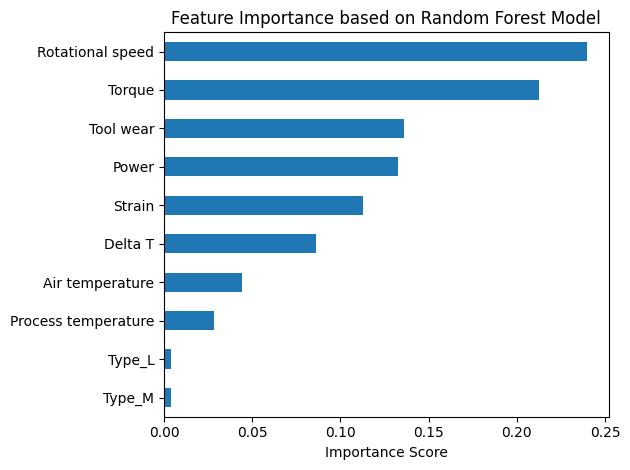

In [66]:
# feature importance
importances = best_rf_model.feature_importances_
feat_importances = pd.Series(importances, index = X_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')
plt.title('Feature Importance based on Random Forest Model')
plt.xlabel('Importance Score')

plt.tight_layout()
plt.show()

100%|===================| 3984/4000 [01:41<00:00]       

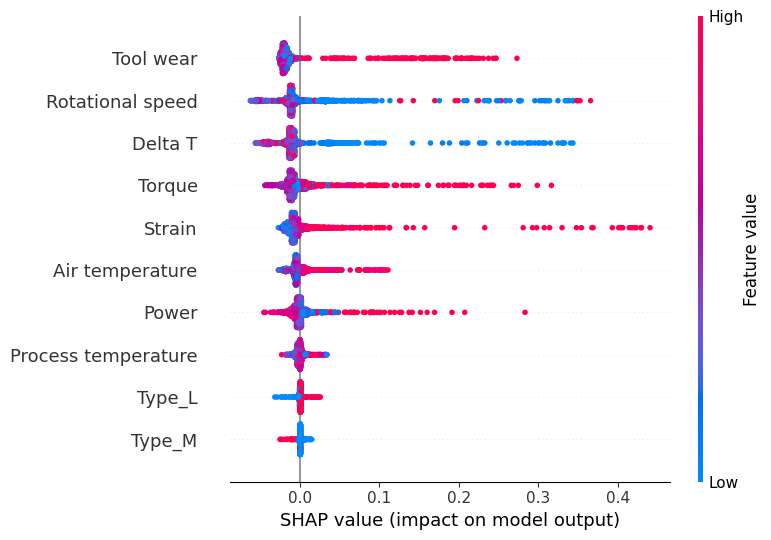

In [67]:
# feature importance using SHAP
import shap

# inisialization
explainer = shap.Explainer(best_rf_model, X_test)

# calculate SHAP values for test dataset
shap_values = explainer(X_test)

# visualization of summary plot
shap.summary_plot(shap_values[:, :, 1], X_test)

**Insight for Importance Analysis**

- `Rotational speed` plays a crucial role in model's learning process, while `Strain` is the primary driver behind high SHAP values
- Specifically, as machine `Strain` increases, the risk of failure escalates drastically
- `Rotational speed` exhibits a non-linear relationship with machine failure. Optimal operational windows are identified, while extreme values (both excessively low and high) strongly correlate with mechanical failure or jamming
- *Low value of `Delta T`* correlate with specific failure types

<br>

Although `Rotational speed` is most frequently used by the model for data differentation, `Strain` is the most critical factor. Once `Strain` exceeds a specific threshold (indicated by the red cluster on the right side), the probability of downtime (machine failure) surges to 70%.

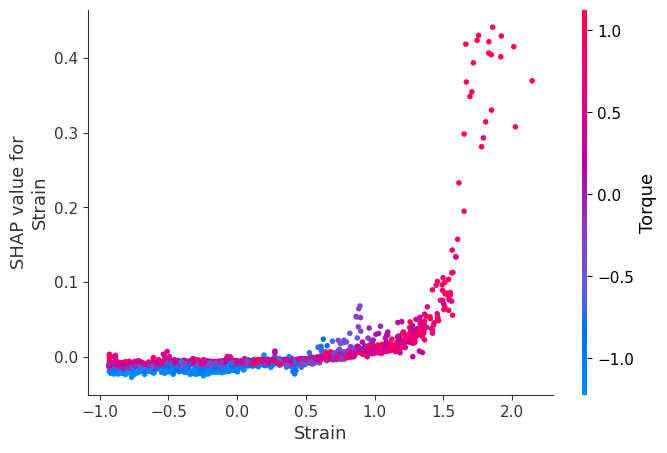

In [68]:
# which feature that most correlated with `Strain`

# Extract the raw SHAP values (numpy array) for the target class (class 1)
# Assuming shap_values.values has shape (n_samples, n_features, n_outputs)
shap_values_array_for_class_1 = shap_values.values[:, :, 1]

# Pass the 2D NumPy array of SHAP values and the feature data to dependence_plot
shap.dependence_plot('Strain', shap_values_array_for_class_1, X_test)

**Insight for `Strain` Dependence Analysis**

- Strain threshold (the *elbow* effect):
  - Safe zone (`Strain` < 0.5)
  - Transition phase (`Strain` 0.5 - 1.5)
  - Danger zone (`Strain` > 1.5)
  - Operational recommendation: implement **Early Warning** system at a `Strain` level of 0.5 and a **Mandatory Emergency Stop** if `Strain` reaches 1.5

- `Power` interaction:
  - High-`Power` value are heavily concentrated in the high SHAP/high `Strain` region
  - Indicates that the combination of high `Strain` and high `Power` is the most lethal scenario for the machine failure.<br> (Physical `Strain` alone is dangerous, but high `Power` consumption significantly exacerbates the mechanical stress, leading to immediate failure).

#### Do these findings align with the documented failure types?

**Additional information given in dataset**
- tool wear failure (TWF): the tool will be replaced of fail at a randomly selected tool wear time between 200 â€“ 240 mins (120 times in our dataset). At this point in time, the tool is replaced 69 times, and fails 51 times (randomly assigned).
- heat dissipation failure (HDF): heat dissipation causes a process failure, if the difference between air and process temperature is below 8.6 K and the toolâ€™s rotational speed is below 1380 rpm. This is the case for 115 data points.
- power failure (PWF): the product of torque and rotational speed (in rad/s) equals the power required for the process. If this power is below 3500 W or above 9000 W, the process fails, which is the case 95 times in our dataset.
- overstrain failure (OSF): if the product of tool wear and torque exceeds 11,000 minNm for the L product variant (12,000 M, 13,000 H), the process fails due to overstrain. This is true for 98 datapoints.
- random failures (RNF): each process has a chance of 0,1 % to fail regardless of its process parameters. This is the case for only 5 datapoints, less than could be expected for 10,000 datapoints in our dataset.

**The principle: physics of failure**

<center>

|Types|Primary Physical Cause|Sensor Indicator|
|---|---|---|
|HDF|Thermodynamic issues|Low `Delta T` + Low `Rotational speed`|
|PWF|Electrical/load imbalance|Extreme `Power`|
|OSF|Mechanical/structural stress|High `Strain`|
|TWF|Material degradation/wear|Cumulative operating time|
|RNF|Stochastic anomalies|Unforeseen errors|

**Model Validation: Feature Importance Insights vs. Failure Types** <br>

1. Overstrain Failure (OSF)
- Alignment: Highly Consistent
- Technical Context: <br>
  In mechanics, overstrain occurs when mechanical stress exceeds the material's elastic limit.
- Data Logic: <br>
  This failure is driven by the accumulation of load (Tool Wear) and torsional force (Torque).
- SHAP Correlation: <br>
  The SHAP dependence plot shows a sharp spike in the Strain feature. This validates that the model correctly identifies when the machine is "forced" to operate beyond its structural integrity.
2. Heat Dissipation Failure (HDF)
- Alignment: Highly Consistent
- Technical Context: <br>
  Industrial machines require effective cooling. If the ambient temperature is too close to the process temperature, thermodynamic laws dictate that heat transfer slows down (poor heat dissipation).
- Data Logic: <br>
  Failure is triggered when the temperature differential ($\Delta T$) is low ($< 8.6$ K) and rotational speed is slow ($< 1380$ RPM), resulting in insufficient airflow/cooling.
- SHAP Correlation: <br>
  This explains why low Delta T (blue points) on the SHAP plot are positioned in the high-risk zone.
3. Power Failure (PWF)
- Alignment: Consistent
- Technical Context: <br>
  Every motor has an "efficiency curve." Operating below the minimum load causes instability, while operating above the maximum load (overload) leads to electrical component overheating.
- Data Logic: <br>
  Failure occurs when Power falls outside the 3500 W – 9000 W range.
- SHAP Correlation: <br>
  The dominance of the Power feature in the model suggests high sensitivity to electrical and mechanical power fluctuations.
4. Tool Wear Failure (TWF)
- Alignment: Consistent
- Technical Context: <br>
  This represents natural degradation; cutting tools have a finite operational lifespan.
- Data Logic: <br>
  These failures occur within specific time intervals (200 – 240 minutes).
- Insight: <br>
  Because this is time-based, the machine learning model captures this as a linear degradation trend leading up to the point of failure.

#### Import to Joblib

In [69]:
import joblib
joblib.dump(best_rf_model, 'best_random_forest.pkl')
joblib.dump(preprocessor, 'preprocessor.pkl')

['preprocessor.pkl']

### Sneakpeek into Multi-Class Report

We will work only with **No Failure** rows in the dataset.

**Feature Engineering**

**on data_train**

In [70]:
X_train_cat_all, y_train_cat = data_engineering(cleaned_train,
                                            train_or_test = 'train',
                                            target_type = 'multiclass')

X_train_cat_all.head()

,Air temperature,Process temperature,Delta T,Tool wear,Rotational speed,Torque,Power,Strain,Type_L,Type_M
0,0.720963,-0.094612,-1.391177,0.356183,-0.135747,-0.519231,-0.700601,-0.012245,1.0,0.0
1,-0.986913,-1.563950,-0.092042,-1.490814,0.054299,0.621795,0.878213,-0.730500,0.0,1.0
2,-1.084506,-0.388480,1.466920,0.945081,-0.108597,0.006410,-0.001201,0.457705,1.0,0.0
3,0.574574,0.272722,-0.698305,0.958465,-0.018100,-0.346154,-0.434915,0.316548,0.0,1.0
4,0.867352,1.521659,0.254394,1.467059,1.004525,-0.442308,-0.236641,0.498315,1.0,0.0


In [71]:
y_train_cat.head()

,Failure type
4536,HDF
2426,PWF
1419,OSF
4121,HDF
5400,OSF


In [72]:
print(len(X_train_cat_all), len(y_train_cat))

271 271


In [73]:
# for future feature selection (in machine learning modeling)
X_train_cat_all.corr()

,Air temperature,Process temperature,Delta T,Tool wear,Rotational speed,Torque,Power,Strain,Type_L,Type_M
Air temperature,1.000000,0.845928,-0.777651,-0.196910,-0.140390,0.049437,-0.014346,-0.122773,-0.042574,0.056609
Process temperature,0.845928,1.000000,-0.322556,-0.057147,-0.093602,0.034782,-0.008460,-0.002140,0.008092,0.018710
Delta T,-0.777651,-0.322556,1.000000,0.282127,0.138833,-0.046742,0.015490,0.215387,0.085105,-0.078419
Tool wear,-0.196910,-0.057147,0.282127,1.000000,-0.131476,0.006605,-0.010737,0.876312,0.144069,-0.160089
Rotational speed,-0.140390,-0.093602,0.138833,-0.131476,1.000000,-0.872389,-0.744433,-0.427965,-0.116753,0.137297
Torque,0.049437,0.034782,-0.046742,0.006605,-0.872389,1.000000,0.965613,0.418084,0.128504,-0.130061
Power,-0.014346,-0.008460,0.015490,-0.010737,-0.744433,0.965613,1.000000,0.401764,0.113570,-0.110292
Strain,-0.122773,-0.002140,0.215387,0.876312,-0.427965,0.418084,0.401764,1.000000,0.191160,-0.202640
Type_L,-0.042574,0.008092,0.085105,0.144069,-0.116753,0.128504,0.113570,0.191160,1.000000,-0.851415
Type_M,0.056609,0.018710,-0.078419,-0.160089,0.137297,-0.130061,-0.110292,-0.202640,-0.851415,1.000000


In [74]:
X_train_cat = dataset_used(X_train_cat_all, feature_to_drop)
X_train_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271 entries, 0 to 270
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air temperature      271 non-null    float64
 1   Process temperature  271 non-null    float64
 2   Delta T              271 non-null    float64
 3   Tool wear            271 non-null    float64
 4   Rotational speed     271 non-null    float64
 5   Torque               271 non-null    float64
 6   Power                271 non-null    float64
 7   Strain               271 non-null    float64
 8   Type_L               271 non-null    float64
 9   Type_M               271 non-null    float64
dtypes: float64(10)
memory usage: 21.3 KB


**on data_test**

In [75]:
X_test_cat_all, y_test_cat = data_engineering(cleaned_test,
                                          train_or_test = 'test',
                                          target_type = 'multiclass')
X_test_cat_all.head()

,Air temperature,Process temperature,Delta T,Tool wear,Rotational speed,Torque,Power,Strain,Type_L,Type_M
0,1.355317,1.301258,-0.871523,-0.687772,-0.027149,-0.089744,-0.098586,-0.380196,1.0,0.0
1,-0.986913,-0.094612,1.640138,0.008198,12.407240,-2.269231,-1.460581,-0.649633,1.0,0.0
2,0.818556,0.052321,-1.391177,-0.995605,-0.063348,0.256410,0.345235,-0.484921,1.0,0.0
3,-1.670063,-1.637416,1.033875,0.128655,-0.289593,0.583397,0.679730,0.218848,0.0,1.0
4,-0.889320,-0.094612,1.466920,1.199378,-0.443439,0.102564,-0.000990,0.629284,1.0,0.0


In [76]:
y_test_cat.head()

,Failure type
4851,HDF
1391,PWF
4495,HDF
8582,PWF
9664,OSF


In [77]:
X_test_cat = dataset_used(X_test_cat_all, feature_to_drop)
X_test_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68 entries, 0 to 67
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Air temperature      68 non-null     float64
 1   Process temperature  68 non-null     float64
 2   Delta T              68 non-null     float64
 3   Tool wear            68 non-null     float64
 4   Rotational speed     68 non-null     float64
 5   Torque               68 non-null     float64
 6   Power                68 non-null     float64
 7   Strain               68 non-null     float64
 8   Type_L               68 non-null     float64
 9   Type_M               68 non-null     float64
dtypes: float64(10)
memory usage: 5.4 KB


**Model learning with handling imbalance**

In [78]:
# RandomForestClassifier

# using best param
best_params = random_forest_tuning.best_params_

multi_rf_model = RandomForestClassifier(
    **best_params,
    class_weight = 'balanced_subsample',
    random_state = 42
)

multi_rf_model.fit(X_train_cat, y_train_cat)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       max_samples=0.6, min_samples_leaf=5,
                       min_samples_split=10, n_estimators=300, random_state=42)

--- Classification Report Multi-class ---
              precision    recall  f1-score   support

         HDF       1.00      1.00      1.00        29
  No Failure       0.00      0.00      0.00         2
         OSF       0.88      1.00      0.94        15
         PWF       0.92      0.92      0.92        12
         TWF       0.80      0.80      0.80        10

    accuracy                           0.93        68
   macro avg       0.72      0.74      0.73        68
weighted avg       0.90      0.93      0.91        68



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


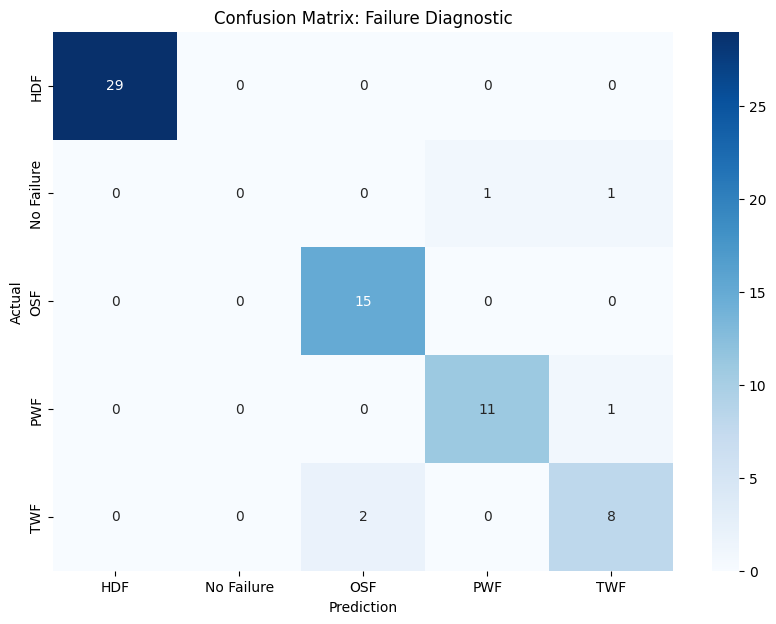

In [79]:
# diagnostic evaluation

y_pred_cat = multi_rf_model.predict(X_test_cat)

# 1. Classification Report
print('--- Classification Report Multi-class ---')
print(classification_report(y_test_cat, y_pred_cat))

# 2. Confusion Matrix Visual
plt.figure(figsize = (10, 7))
cm_cat = confusion_matrix(y_test_cat, y_pred_cat, labels = multi_rf_model.classes_)
sns.heatmap(cm_cat, annot = True, fmt = 'd', cmap = 'Blues',
            xticklabels = multi_rf_model.classes_,
            yticklabels = multi_rf_model.classes_)

plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.title('Confusion Matrix: Failure Diagnostic')
plt.show()

**Work with Threshold moving**

In [80]:
y_probs = multi_rf_model.predict_proba(X_test_cat)
classes = multi_rf_model.classes_
print(f'Class Order: {classes}')

Class Order: ['HDF' 'No Failure' 'OSF' 'PWF' 'TWF']


In [81]:
# assign weight for each class
# higher weight (> 1.0) for RNF and TWF
weights = {
    'No Failure': 0.8,  # slightly penalized due to high dominance (class imbalance)
    'HDF': 3.5,         # good performance, give a small boost
    'PWF': 3.5,         # high weight to improve recall
    'OSF': 2.0,
    'TWF': 4.0,
    'RNF': 5.0          # maximum weight due to extreme minority/scarcity of data
}

# map weights to an array based on the model's class order
weight_array = np.array([weights[cls] for cls in classes])

# multiply raw probabilities by the defined weights
weighted_probs = y_probs * weight_array

# determine new predictions based on the highest weighted probability
y_pred_new = classes[np.argmax(weighted_probs, axis = 1)]

---Outcome After Threshold Moving ---
              precision    recall  f1-score   support

         HDF       1.00      0.97      0.98        29
  No Failure       0.00      0.00      0.00         2
         OSF       0.94      1.00      0.97        15
         PWF       0.92      0.92      0.92        12
         TWF       0.75      0.90      0.82        10

    accuracy                           0.93        68
   macro avg       0.72      0.76      0.74        68
weighted avg       0.91      0.93      0.91        68



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


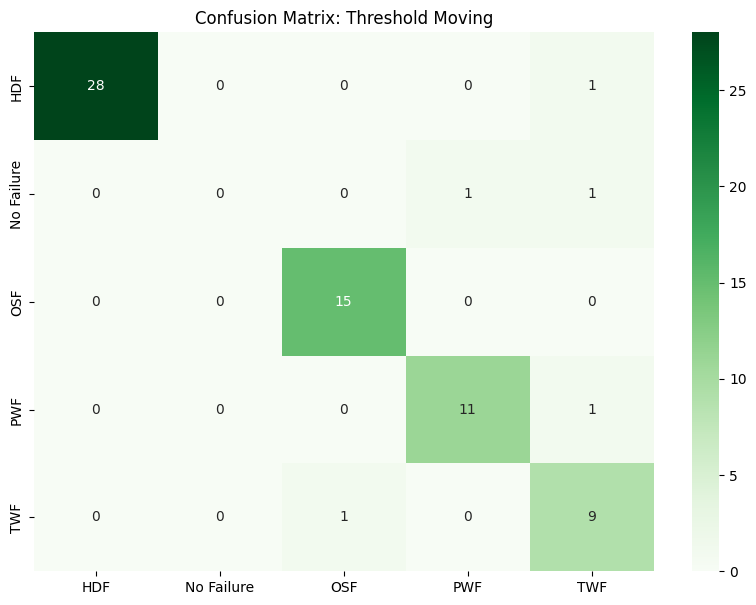

In [82]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print('---Outcome After Threshold Moving ---')
print(classification_report(y_test_cat, y_pred_new))

plt.figure(figsize = (10, 7))
cm_tm = confusion_matrix(y_test_cat, y_pred_new, labels = classes)
sns.heatmap(cm_tm, annot = True, fmt = 'd', cmap = 'Greens', xticklabels = classes, yticklabels = classes)
plt.title('Confusion Matrix: Threshold Moving')
plt.show()

**Why RNF and TWF remain challenging to predict?**

Based on the dataset characteristics, certain failure types are inherently more difficult to predict:

- Random failure <br>
  Since these anomalies do not follow a deterministic logic based on the standard sensor features, they represent *statistical noise* rather than a predictable pattern.
- Tool wear failure <br>
  These failures occur within specific time windows (200-240 mins) but lack a fixed trigger point. <br>
  To capture this type better, the model would likely require more advance time-series features; such as a rolling mean or gradient of tool wear, to identify the subtle degradation patterns leading up to a breakdown.

#### Import to Joblib

In [83]:
import joblib
joblib.dump(multi_rf_model, 'multi_rf_model.pkl')

['multi_rf_model.pkl']

# <font color = 'blue'> Modeling Result
---

## Final Interpretation

**Predictive Maintenance Report: Machine Failure Analysis**

**1. Problem and Solution**
  - Problem <br>
  Unexpected machine downtime results in significant production losses, increased operational costs, and catastrophic tool damage.

  - Solution <br>
  Implementation of a Random Forest Machine Learning model capable of detecting potential failures before they occur, providing real-time diagnostics of the underlying causes.

**2. Key Insights from Model** <br>
Using SHAP and Multi-Class analysis, we have identified the primary triggers for machine failures:
  - `OSF` <br>
  Identified as the highest risk factor. It occurs when the cumulative mechanical load (Strain) crosses the threshold of 0.5 to 1.5.

  - `HDF` <br>
  Detected with high accuracy when the temperature differential (Delta T) narrows below 8.6 K, indicating cooling inefficiency.

  - `PWF` <br>
  Triggered by extreme power fluctuations outside the optimal operating range of 3500W – 9000W.

**3. Actionable Insights**

<center>

|Prediction Status|Sensor Indicator|Operational Recommendations|
|---|---|---|
|Warning: OSF|`Strain` > 0.6|Tool replacement|
|Danger: HDF|`Delta T` < 9K and Low `Rotational speed`|Inspect the cooling system|
|Danger: PWF|`Power` > 8500 W|Voltage stability checking|

## Dashboarding with Streamlit

We will use multiclass random forest (without SMOTE)

In [84]:
# install streamlit
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 117.0 MB/s eta 0:00:00


In [85]:
# NOTES

# features to scale
# ['Type', 'Air temperature', 'Process temperature', 'Rotational speed', 'Torque', 'Tool wear', 'Delta T', 'Power', 'Strain']

# features to fit in modeling
print('Features to fit in modeling: ', X_train.columns.tolist())
print('Features to fit in modeling: ', X_train_cat.columns.tolist())

Features to fit in modeling:  ['Air temperature', 'Process temperature', 'Delta T', 'Tool wear', 'Rotational speed', 'Torque', 'Power', 'Strain', 'Type_L', 'Type_M']
Features to fit in modeling:  ['Air temperature', 'Process temperature', 'Delta T', 'Tool wear', 'Rotational speed', 'Torque', 'Power', 'Strain', 'Type_L', 'Type_M']


In [97]:
# create app.py
%%writefile app.py

import streamlit as st
import pandas as pd
import joblib
import numpy as np

# page configuration
st.set_page_config(page_title = 'Machine Health Dashboard', layout = 'wide')

# load assets (scaler and models)
@st.cache_resource
def load_assets():
  scaler = joblib.load('preprocessor.pkl')
  binary_model = joblib.load('best_random_forest.pkl')    # binary model  : 0/1
  multiclass_model = joblib.load('multi_rf_model.pkl')    # multiclass    : failure type
  return scaler, binary_model, multiclass_model

try:
  scaler, binary_model, multiclass_model = load_assets()
  multi_classes = multiclass_model.classes_
except Exception as e:
  st.error(f'Error loading assets: {e}')
  st.stop()

# header
st.title('Machine Failure Diagnostic Dashboard')
st.markdown('This dashboard predicts machine failure risks based on real-time sensor data.')
st.divider()

# sidebar: data sensor input
st.sidebar.header('Data Sensor Input')

air_temp = st.sidebar.slider('Air temperature', 295.0, 305.0, 300.0)
proc_temp = st.sidebar.slider('Process temperature', 304.0, 315.0, 310.0)
rpm = st.sidebar.number_input('Rotational speed', 1000, 3000, 1500)
torque = st.sidebar.number_input('Torque', 3.0, 80.0, 40.0)
tool_wear = st.sidebar.number_input('Tool wear', 0, 250, 100)
type_m = st.sidebar.selectbox('Type', ['L', 'M', 'H'])

st.sidebar.divider()
st.sidebar.subheader('Sensitivity Settings')
# threshold for binary
threshold = st.sidebar.slider('Failure Detection Threshold', 0.1, 0.9, 0.4)

# feature engineering
raw_input = pd.DataFrame([{
    'Type' : type_m,
    'Air temperature': air_temp,
    'Process temperature': proc_temp,
    'Rotational speed': rpm,
    'Torque': torque,
    'Tool wear': tool_wear,
    'Delta T' : proc_temp - air_temp,
    'Power' : torque * (rpm * (2 * np.pi / 60)),
    'Strain' : torque * tool_wear
}])

# make sure the column order match
cols_order = ['Type', 'Air temperature', 'Process temperature',
              'Rotational speed', 'Torque', 'Tool wear',
              'Delta T', 'Power', 'Strain']

raw_input = raw_input[cols_order]

if st.sidebar.button('Run Diagnostics'):

  # feature transformation with Scaler
  with_robust = ['Rotational speed', 'Torque', 'Power', 'Strain']
  with_standard = ['Air temperature', 'Process temperature', 'Delta T', 'Tool wear']
  with_onehot = ['Type']

  input_scaled = scaler.transform(raw_input)

  try:
    after_onehot = list(scaler.named_transformers_['onehot'].get_feature_names_out(['Type']))
  except:
    after_onehot = ['Type_L', 'Type_M']

  col_names = with_standard + with_robust + after_onehot
  data_after_scaled = pd.DataFrame(input_scaled, columns = col_names)

  # feature selection
  # feature_used = ['Delta T', 'Rotational speed', 'Power', 'Strain', 'Type_L', 'Type_M']
  feature_used = ['Air temperature', 'Process temperature', 'Delta T', 'Tool wear', 'Rotational speed', 'Torque', 'Power', 'Strain', 'Type_L', 'Type_M']
  final_data = data_after_scaled[feature_used]

  # binary prediction
  prob_binary = binary_model.predict_proba(final_data)[0][1]
  col1, col2 = st.columns(2)

  if prob_binary < threshold:
    with col1:
      st.subheader('Diagnostic Results')
      st.success('Machine Status: Normal')
      st.metric('Risk Level', f'{prob_binary*100:.2f}%', delta = f'Below Threshold', delta_color = 'inverse')

    with col2:
      st.subheader('Actionable Insights')
      st.write('**Action:** Continue routine monitoring as per maintenance schedule.')

  else:
    # if failure == 1, use Multiclass model
    multi_probs = multiclass_model.predict_proba(final_data)[0]

    # filtering 'No Filter' values
    prob_map = dict(zip(multi_classes, multi_probs))
    prob_map.pop('No Failure', None)

    # re-calculate max probability
    filtered_classes = list(prob_map.keys())
    filtered_probs = np.array(list(prob_map.values()))
    multi_prediction = filtered_classes[np.argmax(filtered_probs)]

    with col1:
      st.subheader('Diagnostic Results')
      st.error(f'Potential Failure Detected: {multi_prediction}')
      st.metric('Risk Level', f'{prob_binary*100:.2f}%', delta = f'Above Threshold', delta_color = 'inverse')

    with col2:
      st.subheader('Actionable Insights')
      if multi_prediction == 'HDF':
        st.write('**Action:** Inspect cooling system. Thermal differential is too narrow.')
      elif multi_prediction == 'PWF':
        st.write('**Action:** Check torque load or electrical power stability.')
      elif multi_prediction == 'OSF':
        st.write('**Action:** Replace tool immediately due to excessive structural strain.')
      else:
        st.write('**Action:** Continue routine monitoring as per maintenance schedule.')

    # probablity visualization
    if prob_binary >= threshold:
      st.divider()
      st.write('**Failure Type Probability Distribution**')

      prob_df = pd.DataFrame({
          'Failure Type': filtered_classes,
          'Probability (%)': filtered_probs * 100
          }).set_index('Failure Type')

      st.bar_chart(prob_df)

    else:
      st.divider()
      st.info('Probability distribution visualization is only available when a **failure is detected**.')

Overwriting app.py


In [90]:
print(X_train.columns.tolist())

['Air temperature', 'Process temperature', 'Delta T', 'Tool wear', 'Rotational speed', 'Torque', 'Power', 'Strain', 'Type_L', 'Type_M']


In [91]:
print('Feature used in modeling: ', multi_rf_model.feature_names_in_)

Feature used in modeling:  ['Air temperature' 'Process temperature' 'Delta T' 'Tool wear'
 'Rotational speed' 'Torque' 'Power' 'Strain' 'Type_L' 'Type_M']


In [98]:
# install Cloudflare tunnel
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
!dpkg -i cloudflared-linux-amd64.deb

# running the Streamlit in background
import os
os.system('streamlit run app.py &')

# open the tunnel
!cloudflared tunnel --url http://localhost:8501

--2026-01-23 04:05:58--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64.deb
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2026.1.1/cloudflared-linux-amd64.deb [following]
--2026-01-23 04:05:58--  https://github.com/cloudflare/cloudflared/releases/download/2026.1.1/cloudflared-linux-amd64.deb
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/12aae843-3db0-4414-9b56-e2a442db3e76?sp=r&sv=2018-11-09&sr=b&spr=https&se=2026-01-23T04%3A45%3A27Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64.deb&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&